# Turkish Earthquake Clustering Analysis

This notebook implements unsupervised learning techniques to identify intrinsic patterns and risk zones in our AFAD earthquake dataset. While supervised learning (in the companion notebook) predicts specific earthquake magnitudes, unsupervised methods reveal natural groupings and spatial correlations without predefined output variables.

Our multi-faceted unsupervised analysis will:

1. **Discover natural earthquake clusters** using density-based and centroid-based algorithms to identify regions with similar seismic characteristics, potentially corresponding to distinct tectonic regimes or fault systems
   
2. **Identify high-risk seismic zones** by analyzing the spatial density, magnitude distribution, and temporal patterns of earthquake clusters in relation to Turkey's complex fault network
   
3. **Quantify regional vulnerability** for major Turkish population centers by combining seismic pattern data with demographic information to assess potential human impact
   
4. **Visualize multidimensional patterns** through interactive maps, 3D projections, and dimensionality reduction techniques that reveal relationships not visible in raw data

The insights from this unsupervised analysis complement our supervised prediction models by revealing the underlying structure of Turkey's seismic landscape. By identifying natural groupings in the data, we can better understand regional risk variations and potentially improve hazard assessment beyond what is possible with regression models alone.

This approach aligns with modern seismological practice, where clustering analysis is increasingly used to identify seismic sources, aftershock patterns, and earthquake swarms that indicate areas of elevated tectonic stress.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap, MarkerCluster
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import plotly.express as px
import plotly.graph_objects as go
import joblib
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import geopandas as gpd
from shapely.geometry import Point, LineString
import math
import os

# Set visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

# Load the clean earthquake dataset with original coordinates
earthquake_df = pd.read_csv('produced_data/clean_earthquake_data.csv')

# Load fault line data
fault_gdf = gpd.read_file('data\\tr_faults_imp.geojson')
print(f"Number of fault lines: {len(fault_gdf)}")
print(f"Available properties: {fault_gdf.columns.tolist()}")

# Verify coordinate range
print(f"Dataset shape: {earthquake_df.shape}")
print(f"Coordinate ranges:")
print(f"Longitude: {earthquake_df['Longitude'].min():.2f} to {earthquake_df['Longitude'].max():.2f}")
print(f"Latitude: {earthquake_df['Latitude'].min():.2f} to {earthquake_df['Latitude'].max():.2f}")

earthquake_df.head()

Number of fault lines: 926
Available properties: ['fid', 'RATE', 'CONF', 'SENS1', 'SENS2', 'UPSIDE', 'ZONE_NAME', 'FAULT_NAME', 'AUTH', 'PARM', 'TEXT', 'FAULT_ID', 'importance', 'geometry']
Dataset shape: (9829, 31)
Coordinate ranges:
Longitude: 25.00 to 45.00
Latitude: 35.00 to 42.79


,Date,Longitude,Latitude,Depth,Type,Magnitude,Location,EventID,TimeName,TypeName,...,DistFromPrev,PrevDate,DaysSinceLastQuake,PrevMagnitude,distance_to_fault,nearest_fault_name,nearest_fault_importance,fault_count_50km,fault_length_50km,fault_density
0,1900-01-18 15:30:00,28.21,37.79,10.0,MS,4.4,-,7697,Ambraseys-Finkel 1987,Ambraseys-Finkel 1987,...,NaN,NaN,NaN,NaN,3.911122,Buyuk Menderes Graben South,6,8.0,114.936522,0.014634
1,1900-01-24 03:00:00,26.14,39.54,10.0,MS,5.2,-,7698,Ambraseys-Finkel 1987,Ambraseys-Finkel 1987,...,264.871846,1900-01-18 15:30:00,5.479167,4.4,9.556012,Edremit,4,8.0,89.524527,0.011399
2,1900-01-27 02:30:00,37.37,37.63,10.0,MS,4.8,-,7699,Ambraseys-Finkel 1987,Ambraseys-Finkel 1987,...,998.217752,1900-01-24 03:00:00,2.979167,5.2,1.831552,Turkoglu,1,16.0,203.852282,0.025955
3,1900-01-30 01:00:00,27.71,37.83,10.0,MS,4.4,-,7700,Ambraseys-Finkel 1987,Ambraseys-Finkel 1987,...,849.455702,1900-01-27 02:30:00,2.937500,4.8,5.622901,Buyuk Menderes Graben North,4,8.0,114.936522,0.014634
4,1900-02-06 15:09:00,31.29,38.12,10.0,MS,5.7,-,7701,Ambraseys-Finkel 1987,Ambraseys-Finkel 1987,...,315.428868,1900-01-30 01:00:00,7.589583,4.4,15.331402,"Beysehir Graben West, Beysemia",6,6.0,84.977995,0.010820


## 1. Data Preparation for Clustering

Before applying clustering algorithms, we must carefully prepare our earthquake data to ensure meaningful and interpretable results. Unsupervised learning algorithms are particularly sensitive to feature selection, scaling, and preprocessing decisions.

Our preparation process includes:

1. **Feature selection and extraction**:
   - **Spatial coordinates** (Longitude, Latitude): Capturing the geographic distribution of events
   - **Physical parameters** (Depth, Magnitude): Representing earthquake characteristics
   - **Fault proximity metrics**: Calculating the minimum distance from each earthquake to the nearest fault line using spatial geometry algorithms
   - **Fault importance weighting**: Incorporating the classification of fault significance based on historical activity and length

2. **Missing value treatment**:
   - Identifying nulls in each clustering feature
   - Applying median imputation for continuous variables to maintain distributional characteristics
   - Documenting imputation decisions for reproducibility

3. **Feature standardization**:
   - Implementing StandardScaler (z-score normalization) to transform each feature to zero mean and unit variance
   - This step is essential because clustering algorithms use distance metrics that are highly sensitive to feature scales
   - Without standardization, features with larger numerical ranges (like geographic coordinates) would dominate the clustering process

4. **Dimensionality considerations**:
   - Balancing the inclusion of informative features with the "curse of dimensionality"
   - In high-dimensional spaces, distance metrics become less meaningful as points tend to become equidistant
   - Selecting features with clear geophysical relevance to ensure clusters have physical interpretability

The quality of clustering results depends heavily on these preprocessing decisions. By carefully selecting and standardizing features that capture the key aspects of earthquake events, we create a foundation for discovering meaningful patterns that correspond to real geological phenomena rather than artifacts of the data representation.

In [2]:
# If fault features aren't in the data (because we're running this independently of supervised notebook)
# Calculate distance to fault lines
def calc_fault_distance(row, fault_gdf):
    point = Point(row['Longitude'], row['Latitude'])
    
    # Calculate distance to each fault line
    distances = []
    for idx, fault in fault_gdf.iterrows():
        fault_geom = fault.geometry
        dist = point.distance(fault_geom)
        distances.append((dist, idx))
    
    # Find the closest fault
    closest_dist, closest_idx = min(distances, key=lambda x: x[0])
    
    # Convert distance to kilometers (approximation)
    # 1 degree ≈ 111 km at the equator
    dist_km = closest_dist * 111
    
    # Get fault properties
    closest_fault = fault_gdf.iloc[closest_idx]
    
    return pd.Series({
        'distance_to_fault': dist_km,
        'nearest_fault_name': closest_fault.get('FAULT_NAME', 'Unknown'),
        'nearest_fault_importance': closest_fault.get('importance', 0)
    })

# Only calculate if these features don't exist yet
if 'distance_to_fault' not in earthquake_df.columns:
    print("Calculating fault distances...")
    # Process in batches to avoid memory issues
    batch_size = 1000
    all_results = []
    
    for i in range(0, len(earthquake_df), batch_size):
        batch_end = min(i + batch_size, len(earthquake_df))
        print(f"Processing batch {i} to {batch_end}...")
        batch = earthquake_df.iloc[i:batch_end]
        results = batch.apply(lambda row: calc_fault_distance(row, fault_gdf), axis=1)
        all_results.append(results)
    
    fault_features = pd.concat(all_results)
    earthquake_df = pd.concat([earthquake_df, fault_features], axis=1)

# Select features for clustering
# Include geographic features and fault-related features for spatial clustering
clustering_features = ['Longitude', 'Latitude', 'Depth', 'Magnitude']

# Add fault-related features if available
fault_features = ['distance_to_fault', 'nearest_fault_importance']
for feature in fault_features:
    if feature in earthquake_df.columns:
        clustering_features.append(feature)

# Create a subset of data for clustering
cluster_data = earthquake_df[clustering_features].copy()

# Check for missing values
print("Missing values in clustering features:")
print(cluster_data.isnull().sum())

# Fill any missing values if needed
cluster_data.fillna(cluster_data.median(), inplace=True)

# Standardize features for clustering algorithms
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_data)
scaled_df = pd.DataFrame(scaled_data, columns=clustering_features)

print("Data prepared for clustering:")
scaled_df.describe()

# Create directories if they don't exist
os.makedirs("maps", exist_ok=True)
os.makedirs("models", exist_ok=True)
os.makedirs("produced_data", exist_ok=True)

print("Created output directories: maps, models, produced_data")

Missing values in clustering features:
Longitude                   0
Latitude                    0
Depth                       0
Magnitude                   0
distance_to_fault           0
nearest_fault_importance    0
dtype: int64
Data prepared for clustering:
Created output directories: maps, models, produced_data


## 2. K-Means Clustering

K-Means clustering will partition our earthquake data into distinct groups based on feature similarity, potentially revealing natural seismic zones across Turkey's complex tectonic landscape. This centroid-based algorithm assigns each earthquake to the nearest of k cluster centers, then iteratively refines these centers.

Our K-Means implementation follows these steps:

1. **Optimal cluster number determination**:
   - **Elbow Method**: Plotting inertia (sum of squared distances to nearest centroid) across different k values to identify the point of diminishing returns
   - **Silhouette Analysis**: Calculating the mean silhouette coefficient, which measures how similar points are to their assigned cluster versus other clusters
   - **Domain knowledge integration**: Considering Turkey's known tectonic regions when interpreting optimal k values

2. **Algorithm application**:
   - Implementing K-Means with the sklearn library using the determined optimal k
   - Using multiple random initializations (n_init=10) to avoid local minima
   - Ensuring convergence with sufficient iterations

3. **Cluster analysis**:
   - Examining the distribution of earthquakes across clusters
   - Calculating cluster-specific statistics (mean magnitude, depth, etc.)
   - Assessing geographical coherence of the resulting clusters

4. **Validation**:
   - Evaluating cluster separation using silhouette scores
   - Assessing cluster stability across different random initializations

K-Means is particularly effective for identifying general earthquake zones that might correspond to distinct tectonic provinces or fault systems. For example, separate clusters might emerge along the North Anatolian Fault versus the East Anatolian Fault, reflecting their different seismic characteristics. The resulting partition provides a macroscopic view of Turkey's seismic landscape, although K-Means' preference for spherical clusters may limit its ability to capture irregularly shaped seismic zones.

K=2, Inertia=45014.32, Silhouette Score=0.264
K=3, Inertia=37861.91, Silhouette Score=0.255
K=4, Inertia=32814.84, Silhouette Score=0.219
K=5, Inertia=28982.28, Silhouette Score=0.234
K=6, Inertia=25693.24, Silhouette Score=0.246
K=7, Inertia=23924.56, Silhouette Score=0.245
K=8, Inertia=22587.68, Silhouette Score=0.232
K=9, Inertia=21171.34, Silhouette Score=0.249
K=10, Inertia=20035.03, Silhouette Score=0.223
K=11, Inertia=19173.31, Silhouette Score=0.247


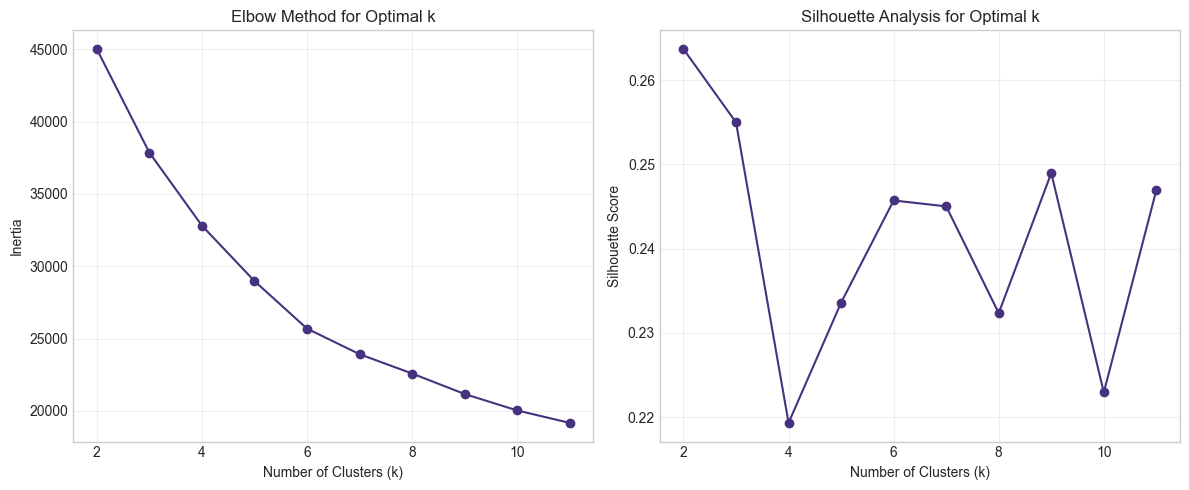

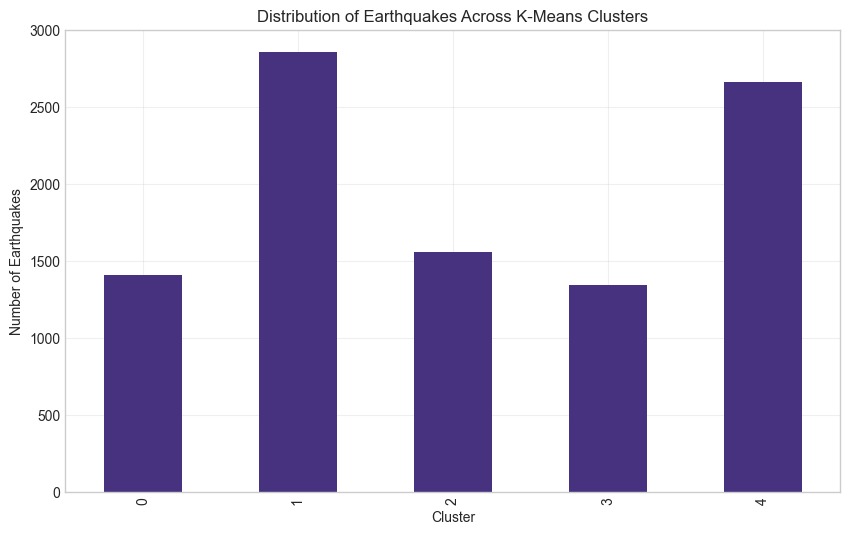

In [ ]:
# Determine optimal number of clusters using the Elbow Method
inertia = []
silhouette_scores = []
k_range = range(2, 12)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)
    
    # Compute silhouette score
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(scaled_data, labels)
    silhouette_scores.append(silhouette_avg)
    
    print(f"K={k}, Inertia={kmeans.inertia_:.2f}, Silhouette Score={silhouette_avg:.3f}")

# Plot the Elbow Method results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, 'o-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'o-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal k')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Select the optimal k based on the elbow method and silhouette score
optimal_k = 5

# Apply K-Means with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(scaled_data)

# Add cluster labels to the original dataframe
earthquake_df['KMeans_Cluster'] = cluster_labels

# Display the distribution of clusters
plt.figure(figsize=(10, 6))
cluster_counts = earthquake_df['KMeans_Cluster'].value_counts().sort_index()
cluster_counts.plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Number of Earthquakes')
plt.title('Distribution of Earthquakes Across K-Means Clusters')
plt.grid(True, alpha=0.3)
plt.show()

## 3. Visualizing K-Means Clusters

Visualizing the identified clusters helps interpret their geological significance and spatial distribution across Turkey. These visualizations transform abstract mathematical groupings into meaningful patterns that can be related to tectonic features.

We'll implement multiple visualization approaches:

1. **Interactive geographic mapping**:
   - Creating a Folium-based map with cluster-specific coloring
   - Adding circle markers sized by magnitude and colored by cluster assignment
   - Overlaying major fault lines with importance-based styling
   - Visualizing cluster centroids as larger markers to show the focal point of each group
   - Adding interactive popups with detailed earthquake information

2. **Cluster characteristic analysis**:
   - Generating parallel coordinate plots showing feature distributions within each cluster
   - Creating violin plots comparing magnitude and depth distributions across clusters
   - Calculating and visualizing the mean characteristics of each cluster (depth, magnitude, fault proximity)

3. **Fault relationship visualization**:
   - Plotting the distance relationship between cluster members and nearest faults
   - Visualizing how clusters align with major fault systems
   - Analyzing whether certain clusters consistently occur near specific fault types

4. **3D visualization**:
   - Implementing interactive 3D scatter plots incorporating longitude, latitude, and depth
   - Using color to represent cluster assignment and size to encode magnitude
   - Enabling rotation and zooming to explore the subsurface distribution of clusters

These visualizations help answer key questions about the identified clusters:
- Do earthquakes naturally group by geographic region, depth profile, or magnitude range?
- How do cluster boundaries relate to known geological features like fault zones?
- Are certain clusters characterized by specific types of seismic activity?
- How does the 3D distribution of clusters relate to subsurface tectonic structures?

By visually exploring these relationships, we can begin translating mathematical clusters into geologically meaningful interpretations about Turkey's seismic patterns.

In [ ]:
# Analyze cluster characteristics
cluster_analysis = earthquake_df.groupby('KMeans_Cluster').agg({
    'Longitude': 'mean',
    'Latitude': 'mean',
    'Depth': 'mean',
    'Magnitude': 'mean',
    'KMeans_Cluster': 'count'
}).rename(columns={'KMeans_Cluster': 'Count'})

# Add fault distance stats if available
if 'distance_to_fault' in earthquake_df.columns:
    fault_stats = earthquake_df.groupby('KMeans_Cluster').agg({
        'distance_to_fault': ['mean', 'min'],
        'nearest_fault_importance': 'mean'
    })
    
    # Flatten MultiIndex columns
    fault_stats.columns = ['_'.join(col).strip() for col in fault_stats.columns.values]
    cluster_analysis = pd.concat([cluster_analysis, fault_stats], axis=1)

print("Cluster characteristics:")
print(cluster_analysis)

# Create K-means map visualization with folium - FIXED coordinates
kmeans_map = folium.Map(location=[38.5, 35.5], zoom_start=6)

# Create a discrete color map for clusters
cluster_colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'darkblue', 'cadetblue']

# Add clusters as markers, ensuring coordinates are within Turkey's boundaries
for idx, row in earthquake_df.iterrows():
    cluster_idx = int(row['KMeans_Cluster']) % len(cluster_colors)
    color = cluster_colors[cluster_idx]
    
    # Use the enhanced radius calculation from risk map
    if row['Magnitude'] >= 7:
        # Much more exponential growth for major earthquakes
        radius = 15 + ((row['Magnitude'] - 7) ** 2) * 6
    else:
        radius = 3 + (row['Magnitude'] - 4) ** 1.5  # Exponential growth
    
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],  # Latitude first, Longitude second
        radius=radius,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"Cluster: {row['KMeans_Cluster']}<br>Magnitude: {row['Magnitude']}"
    ).add_to(kmeans_map)

# Add cluster centers as larger markers
for cluster_id, group in earthquake_df.groupby('KMeans_Cluster'):
    center_lat = group['Latitude'].mean()
    center_lon = group['Longitude'].mean()
    cluster_idx = int(cluster_id) % len(cluster_colors)
    color = cluster_colors[cluster_idx]
    
    folium.CircleMarker(
        location=[center_lat, center_lon],  # Latitude first, Longitude second
        radius=8,
        color='black',
        fill=True,
        fill_color=color,
        fill_opacity=0.9,
        popup=f"Cluster Center {cluster_id}"
    ).add_to(kmeans_map)

# Add fault lines to the map
def add_faults_to_map(map_obj, fault_gdf, importance_threshold=0):
    # Filter faults by importance if desired
    if importance_threshold > 0:
        fault_data = fault_gdf[fault_gdf['importance'] >= importance_threshold]
    else:
        fault_data = fault_gdf
    
    # Color by importance
    def style_function(feature):
        importance = feature['properties']['importance']
        color = '#FF0000' if importance >= 4 else '#FFA500' if importance >= 3 else '#FFFF00'
        return {
            'color': color,
            'weight': importance * 0.5,  # Thicker lines for more important faults
            'opacity': 0.7
        }
    
    # Add GeoJSON to map
    folium.GeoJson(
        fault_data,
        name='Fault Lines',
        style_function=style_function,
        tooltip=folium.GeoJsonTooltip(fields=['FAULT_NAME', 'importance']),
    ).add_to(map_obj)
    
    return map_obj

# Add fault lines to the map
kmeans_map = add_faults_to_map(kmeans_map, fault_gdf, importance_threshold=3)

# Add better tile layer
folium.TileLayer('cartodbpositron').add_to(kmeans_map)

# Add layer control
folium.LayerControl().add_to(kmeans_map)

# For K-means map legend
kmeans_legend_html = '''
<div style="position: fixed; bottom: 50px; right: 50px; width: 200px; 
    background-color: white; border:2px solid grey; z-index:9999; 
    padding: 10px; border-radius: 5px; font-family: Arial;">
    <h4 style="margin-top:0;">K-Means Clusters</h4>
    
    <div style="margin-top:5px;">
      <p><b>Cluster Colors:</b></p>
      <div style="display: flex; align-items: center; margin-bottom: 5px;">
        <div style="background-color: red; width: 15px; height: 15px; margin-right: 5px; border-radius: 50%;"></div>
        <span>Cluster 0</span>
      </div>
      <div style="display: flex; align-items: center; margin-bottom: 5px;">
        <div style="background-color: blue; width: 15px; height: 15px; margin-right: 5px; border-radius: 50%;"></div>
        <span>Cluster 1</span>
      </div>
      <div style="display: flex; align-items: center; margin-bottom: 5px;">
        <div style="background-color: green; width: 15px; height: 15px; margin-right: 5px; border-radius: 50%;"></div>
        <span>Cluster 2</span>
      </div>
      <div style="display: flex; align-items: center; margin-bottom: 5px;">
        <div style="background-color: purple; width: 15px; height: 15px; margin-right: 5px; border-radius: 50%;"></div>
        <span>Cluster 3</span>
      </div>
      <div style="display: flex; align-items: center; margin-bottom: 5px;">
        <div style="background-color: orange; width: 15px; height: 15px; margin-right: 5px; border-radius: 50%;"></div>
        <span>Cluster 4</span>
      </div>
    </div>
    
    <div style="margin-top:10px;">
      <p><b>Marker Size:</b> Proportional to earthquake magnitude</p>
    </div>
    
    <div style="margin-top:10px;">
      <p><b>Fault Line Importance:</b></p>
      <p><span style="color:#FF0000;">━━━</span> High (4+)</p>
      <p><span style="color:#FFA500;">━━━</span> Medium (3)</p>
      <p><span style="color:#FFFF00;">━━━</span> Low (<3)</p>
    </div>
</div>
'''
kmeans_map.get_root().html.add_child(folium.Element(kmeans_legend_html))

# Save the map
kmeans_map.save('maps/kmeans_clusters_map.html')
print("K-means cluster map saved as 'maps/kmeans_clusters_map.html'")

# Also create a Plotly version for the notebook 
fig_kmeans = px.scatter_mapbox(
    earthquake_df.sample(min(3000, len(earthquake_df))), 
    lat='Latitude',  # Ensure correct parameter for latitude 
    lon='Longitude',  # Ensure correct parameter for longitude
    color='KMeans_Cluster',
    size='Magnitude',
    color_continuous_scale=px.colors.qualitative.Bold,
    size_max=15,
    zoom=5,
    center={"lat": 38.5, "lon": 35.5},  # Centered on Turkey
    mapbox_style="open-street-map",
    title='K-Means Clusters of Turkish Earthquakes',
    hover_data=['Depth', 'Magnitude', 'KMeans_Cluster']
)
fig_kmeans.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
fig_kmeans.write_html('maps/kmeans_clusters_map_plotly.html')

Cluster characteristics:
                Longitude   Latitude      Depth  Magnitude  Count  \
KMeans_Cluster                                                      
0               29.681750  36.752550  51.333862   4.597653   1406   
1               28.764406  38.586180  13.420133   4.380476   2858   
2               32.540850  38.967310  15.760807   4.486483   1561   
3               27.968495  35.803784  19.784154   4.362789   1341   
4               40.676509  39.199156  13.751341   4.454112   2663   

                distance_to_fault_mean  distance_to_fault_min  \
KMeans_Cluster                                                  
0                            56.264959               0.003352   
1                            21.544112               0.001776   
2                            14.466071               0.003379   
3                           146.383562              54.046748   
4                            23.168106               0.002047   

                nearest_fault_impor

In [5]:
# Create a 3D scatter plot of KMeans clusters with fault information
fig = px.scatter_3d(
    earthquake_df.sample(min(5000, len(earthquake_df))), 
    x='Longitude', 
    y='Latitude', 
    z='Depth',
    color='KMeans_Cluster', 
    size='Magnitude',
    color_continuous_scale=px.colors.qualitative.Bold,
    hover_data=['distance_to_fault', 'nearest_fault_importance'] if 'distance_to_fault' in earthquake_df.columns else None,
    title='3D Visualization of KMeans Earthquake Clusters'
)

# Ensure proper axis orientation and labels
fig.update_layout(scene=dict(
    xaxis_title='Longitude',
    yaxis_title='Latitude',
    zaxis_title='Depth (km)',
    zaxis=dict(autorange="reversed")  # Reverse depth axis so deeper is lower
))

# Save the interactive 3D visualization
fig.write_html('maps/kmeans_clusters_3d.html')
print("3D KMeans visualization saved to maps/kmeans_clusters_3d.html")

3D KMeans visualization saved to maps/kmeans_clusters_3d.html


## 4. DBSCAN Clustering

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) offers several advantages over K-Means for earthquake analysis, as it can identify clusters of arbitrary shape based on local density characteristics. This approach is particularly suitable for seismic data, where earthquake distributions often follow irregular fault geometries.

DBSCAN's key characteristics and implementation steps include:

1. **Density-based cluster definition**:
   - **Core points**: Points with at least `min_samples` neighbors within distance `epsilon`
   - **Directly reachable points**: Points within `epsilon` distance of a core point
   - **Density-connected points**: Points connected through chains of directly reachable points
   - **Noise points**: Points that don't belong to any cluster, labeled as -1

2. **Parameter selection methodology**:
   - **Epsilon determination**: Using k-distance graphs to identify the "elbow point" where distance to kth nearest neighbor increases significantly
   - **Min_samples tuning**: Balancing between too many small clusters and too few large clusters
   - **Domain knowledge integration**: Considering the expected spatial density of earthquakes along fault systems

3. **Key advantages for seismological applications**:
   - **No predefined cluster number**: Automatically determines the number of clusters based on data density
   - **Irregular cluster shapes**: Can identify elongated clusters that may follow fault lines
   - **Noise identification**: Explicitly identifies outliers/noise points, which may represent isolated events
   - **Variable density handling**: Can detect clusters of varying densities with appropriate parameterization

4. **Implementation challenges**:
   - **Parameter sensitivity**: Results highly dependent on epsilon and min_samples values
   - **Varying densities**: Potential difficulty with regions of significantly different earthquake densities
   - **High-dimensional limitations**: Reduced effectiveness in high-dimensional feature spaces due to distance concentration

DBSCAN may reveal micro-regions with distinct earthquake patterns that K-Means would merge into larger clusters. For example, it might identify elongated clusters following specific fault segments or isolate unusual earthquake swarms that don't fit the broader regional pattern. These fine-grained insights complement the more general groupings from K-Means.

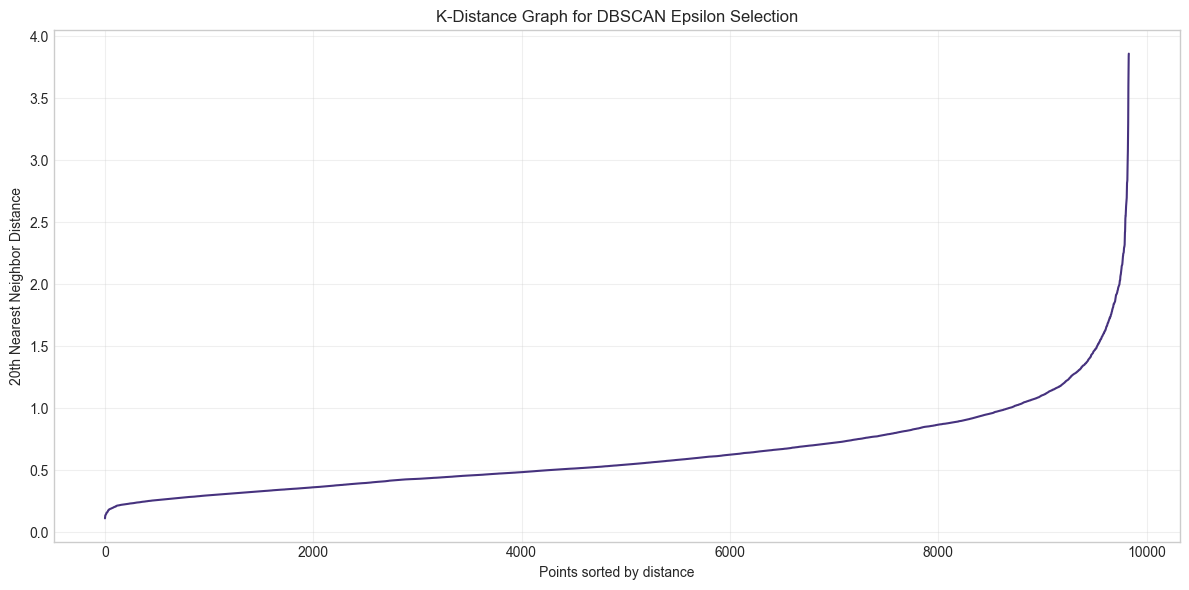

DBSCAN found 14 clusters and 3826 noise points.
Percentage of noise points: 38.93%


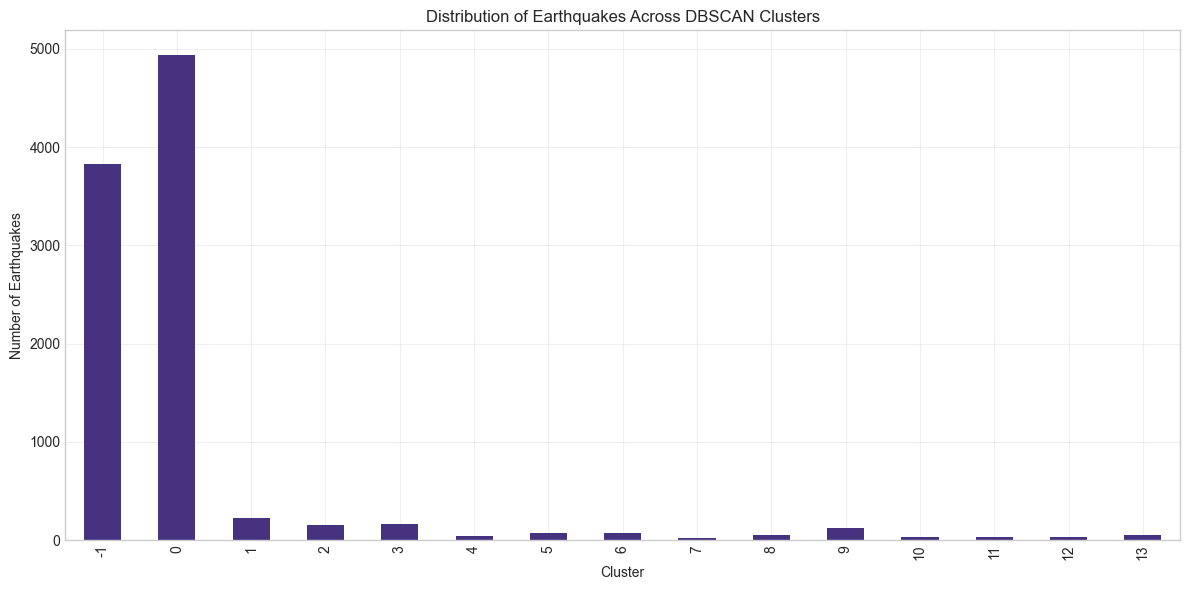

In [6]:
# Apply DBSCAN clustering
# We need to find appropriate epsilon and min_samples values
from sklearn.neighbors import NearestNeighbors

# Determine epsilon using k-distance graph
neighbors = NearestNeighbors(n_neighbors=20)
neighbors_fit = neighbors.fit(scaled_data)
distances, indices = neighbors_fit.kneighbors(scaled_data)

# Sort distances for k-distance graph
distances = np.sort(distances, axis=0)
distances = distances[:, 19]  # 20th neighbor

# Plot k-distance graph
plt.figure(figsize=(12, 6))
plt.plot(distances)
plt.xlabel('Points sorted by distance')
plt.ylabel('20th Nearest Neighbor Distance')
plt.title('K-Distance Graph for DBSCAN Epsilon Selection')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Based on the k-distance plot, choose an appropriate epsilon
# Look for the "elbow" in the plot
epsilon = 0.5  # Adjust based on the plot
min_samples = 20  # Minimum neighbors for a core point

# Apply DBSCAN with chosen parameters
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(scaled_data)

# Add DBSCAN labels to the dataframe
earthquake_df['DBSCAN_Cluster'] = dbscan_labels

# Count the number of clusters and noise points
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"DBSCAN found {n_clusters} clusters and {n_noise} noise points.")
print(f"Percentage of noise points: {n_noise / len(dbscan_labels) * 100:.2f}%")

# Display the distribution of DBSCAN clusters
plt.figure(figsize=(12, 6))
cluster_counts = earthquake_df['DBSCAN_Cluster'].value_counts().sort_index()
cluster_counts.plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Number of Earthquakes')
plt.title('Distribution of Earthquakes Across DBSCAN Clusters')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Visualizing DBSCAN Clusters

Visualizing DBSCAN clusters reveals density-based earthquake patterns and outlier events that may have special significance. These visualizations highlight the advantage of density-based clustering for identifying irregularly shaped seismic zones and isolated events.

Our DBSCAN visualization approach includes:

1. **Spatial distribution mapping**:
   - Creating an interactive Folium map with distinct colors for each DBSCAN cluster
   - Using a special designation (typically black) for noise points that don't belong to any cluster
   - Differentiating marker size by magnitude to show energy distribution
   - Overlaying major fault systems to examine cluster-fault relationships
   - Implementing interactive elements for detailed exploration

2. **Density heatmap creation**:
   - Generating kernel density estimation (KDE) heatmaps to visualize earthquake concentration
   - Using Plotly's density_mapbox to create interactive density visualizations
   - Comparing density patterns with identified clusters to verify alignment

3. **Cluster vs. noise analysis**:
   - Creating comparative visualizations of clustered points versus noise points
   - Analyzing the characteristics (magnitude, depth, temporal distribution) of noise points
   - Determining whether noise points represent truly anomalous events or sampling artifacts

4. **3D visualization with density encoding**:
   - Implementing 3D scatter plots with longitude, latitude, and depth
   - Encoding cluster assignment through color and density through opacity
   - Identifying potential subsurface patterns in cluster formation

These visualizations address important questions about density-based earthquake patterns:
- Do high-density earthquake zones correspond to known fault systems?
- What characteristics distinguish noise points from clustered events?
- Do certain regions show more scattered activity while others show tight clustering?
- How do the density-based clusters compare with the centroid-based (K-Means) clusters?

By examining these density-based patterns, we gain insights into areas of concentrated seismic activity that may represent zones of elevated strain release or tectonic stress accumulation. The noise points are equally important, as they may represent unusual events worth individual investigation.

In [ ]:
# Create DBSCAN map visualization with folium
dbscan_map = folium.Map(location=[38.5, 35.5], zoom_start=6)

# Number of clusters excluding noise
num_clusters = len(set(earthquake_df['DBSCAN_Cluster'])) - (1 if -1 in earthquake_df['DBSCAN_Cluster'].values else 0)
colormap = cm.get_cmap('tab20', max(num_clusters + 1, 2))  # +1 for noise points

# Function to get color for cluster
def get_cluster_color(cluster_id):
    if cluster_id == -1:  # Noise points
        return '#000000'  # Black
    else:
        rgba = colormap(cluster_id % max(num_clusters, 1))
        return mcolors.rgb2hex(rgba)

# Add data points with proper colors (no sampling)
for idx, row in earthquake_df.iterrows():
    cluster_id = int(row['DBSCAN_Cluster'])
    color = get_cluster_color(cluster_id)
    
    # Use the enhanced radius calculation from risk map
    if row['Magnitude'] >= 7:
        # Much more exponential growth for major earthquakes
        radius = 15 + ((row['Magnitude'] - 7) ** 2) * 6
    else:
        radius = 3 + (row['Magnitude'] - 4) ** 1.5  # Exponential growth
    
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],  # Latitude first, then Longitude
        radius=radius,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7 if cluster_id != -1 else 0.3,  # Make noise points more transparent
        popup=f"Cluster: {cluster_id}<br>Magnitude: {row['Magnitude']}"
    ).add_to(dbscan_map)

# Add fault lines to the map
dbscan_map = add_faults_to_map(dbscan_map, fault_gdf, importance_threshold=3)

# Add better tile layer
folium.TileLayer('cartodbpositron').add_to(dbscan_map)

# Add layer control
folium.LayerControl().add_to(dbscan_map)

# For DBSCAN map legend
dbscan_legend_html = '''
<div style="position: fixed; bottom: 50px; right: 50px; width: 200px; 
    background-color: white; border:2px solid grey; z-index:9999; 
    padding: 10px; border-radius: 5px; font-family: Arial;">
    <h4 style="margin-top:0;">DBSCAN Clusters</h4>
    
    <div style="margin-top:5px;">
      <p><b>Cluster Colors:</b> Each color represents a distinct spatial cluster</p>
      <div style="display: flex; align-items: center; margin-bottom: 5px;">
        <div style="background-color: black; width: 15px; height: 15px; margin-right: 5px; border-radius: 50%; opacity: 0.3;"></div>
        <span>Noise points (-1)</span>
      </div>
    </div>
    
    <div style="margin-top:10px;">
      <p><b>Marker Size:</b> Proportional to earthquake magnitude</p>
    </div>
    
    <div style="margin-top:10px;">
      <p><b>Fault Line Importance:</b></p>
      <p><span style="color:#FF0000;">━━━</span> High (4+)</p>
      <p><span style="color:#FFA500;">━━━</span> Medium (3)</p>
      <p><span style="color:#FFFF00;">━━━</span> Low (<3)</p>
    </div>
</div>
'''
dbscan_map.get_root().html.add_child(folium.Element(dbscan_legend_html))

# Save the map
dbscan_map.save('maps/dbscan_clusters_map.html')
print("DBSCAN cluster map saved as 'maps/dbscan_clusters_map.html'")

# Also create a Plotly version for the notebook
fig_dbscan = px.scatter_mapbox(
    earthquake_df.sample(min(3000, len(earthquake_df))), 
    lat='Latitude',  # Correct parameter for latitude
    lon='Longitude',  # Correct parameter for longitude
    color='DBSCAN_Cluster',
    size='Magnitude',
    color_continuous_scale=px.colors.qualitative.Dark24,
    size_max=15,
    zoom=5,
    center={"lat": 38.5, "lon": 35.5},  # Centered on Turkey
    mapbox_style="open-street-map",
    title='DBSCAN Clusters of Turkish Earthquakes',
    hover_data=['Depth', 'Magnitude', 'DBSCAN_Cluster']
)
fig_dbscan.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
fig_dbscan.write_html('maps/dbscan_clusters_map_plotly.html')

C:\Users\Sarp Can\AppData\Local\Temp\ipykernel_23888\4161209598.py:6: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



DBSCAN cluster map saved as 'maps/dbscan_clusters_map.html'


In [8]:
# Create density heatmap with Plotly
fig_density = px.density_mapbox(
    earthquake_df, 
    lat='Latitude',  # Correct parameter for latitude
    lon='Longitude',  # Correct parameter for longitude
    z='Magnitude',
    radius=10,
    zoom=5, 
    center={"lat": 38.5, "lon": 35.5},  # Centered on Turkey
    mapbox_style="open-street-map",
    title='Earthquake Density Heatmap'
)
fig_density.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
fig_density.write_html('maps/earthquake_density_map.html')

# Analyze DBSCAN cluster characteristics
dbscan_analysis = earthquake_df[earthquake_df['DBSCAN_Cluster'] != -1].groupby('DBSCAN_Cluster').agg({
    'Longitude': 'mean',
    'Latitude': 'mean',
    'Depth': 'mean',
    'Magnitude': 'mean',
    'DBSCAN_Cluster': 'count'
}).rename(columns={'DBSCAN_Cluster': 'Count'})

# Add fault distance stats if available
if 'distance_to_fault' in earthquake_df.columns:
    fault_stats_dbscan = earthquake_df[earthquake_df['DBSCAN_Cluster'] != -1].groupby('DBSCAN_Cluster').agg({
        'distance_to_fault': ['mean', 'min'],
        'nearest_fault_importance': 'mean'
    })
    
    # Flatten MultiIndex columns
    fault_stats_dbscan.columns = ['_'.join(col).strip() for col in fault_stats_dbscan.columns.values]
    dbscan_analysis = pd.concat([dbscan_analysis, fault_stats_dbscan], axis=1)

print("DBSCAN cluster characteristics (excluding noise):")
print(dbscan_analysis)

# Noise point characteristics
noise_points = earthquake_df[earthquake_df['DBSCAN_Cluster'] == -1]
print("\nNoise point characteristics:")
print(noise_points[['Longitude', 'Latitude', 'Depth', 'Magnitude']].describe())

# Calculate average distance to fault for noise points if available
if 'distance_to_fault' in earthquake_df.columns:
    print("\nNoise points fault distance statistics:")
    print(noise_points[['distance_to_fault', 'nearest_fault_importance']].describe())

DBSCAN cluster characteristics (excluding noise):
                Longitude   Latitude      Depth  Magnitude  Count  \
DBSCAN_Cluster                                                      
0               31.501174  37.878979  16.773979   4.295183   4941   
1               27.914080  39.314799   9.365247   4.148879    223   
2               39.193661  38.289184   8.888129   4.202581    155   
3               43.527623  42.499838   9.839207   4.302439    164   
4               31.258191  36.055167  59.935870   4.232609     46   
5               29.030301  40.642986   8.502464   4.156522     69   
6               38.321630  38.047958   8.506232   4.240580     69   
7               42.140138  40.346081  34.114286   4.604762     21   
8               38.254742  37.990031   8.088654   4.132692     52   
9               37.862972  37.881304   8.736885   4.267213    122   
10              28.078815  36.917815  10.119091   4.166667     33   
11              33.887653  40.752200   8.693333   4.0

In [9]:
# Create a 3D scatter plot of DBSCAN clusters with fault information if available
if 'distance_to_fault' in earthquake_df.columns:
    fig = px.scatter_3d(
        earthquake_df.sample(min(5000, len(earthquake_df))), 
        x='Longitude', 
        y='Latitude', 
        z='Depth',
        color='DBSCAN_Cluster', 
        size='Magnitude',
        color_continuous_scale=px.colors.qualitative.G10,
        hover_data=['distance_to_fault', 'nearest_fault_importance'],
        title='3D Visualization of DBSCAN Earthquake Clusters with Fault Information'
    )
else:
    fig = px.scatter_3d(
        earthquake_df.sample(min(5000, len(earthquake_df))), 
        x='Longitude', 
        y='Latitude', 
        z='Depth',
        color='DBSCAN_Cluster', 
        size='Magnitude',
        color_continuous_scale=px.colors.qualitative.G10,
        title='3D Visualization of DBSCAN Earthquake Clusters'
    )
# Ensure proper axis orientation and labels
fig.update_layout(scene=dict(
    xaxis_title='Longitude',
    yaxis_title='Latitude',
    zaxis_title='Depth (km)',
    zaxis=dict(autorange="reversed")  # Reverse depth axis so deeper is lower
))
fig.write_html('maps/dbscan_clusters_3d.html')

## 6. Dimensionality Reduction with PCA

Principal Component Analysis (PCA) helps visualize high-dimensional earthquake data in a reduced 2D space, revealing patterns and relationships that might not be evident in the original feature space. This technique is particularly valuable for understanding the structure of multivariate geophysical data.

Our PCA implementation and analysis includes:

1. **Mathematical foundation**:
   - **Linear transformation**: Finding orthogonal axes (principal components) that maximize variance
   - **Eigendecomposition**: Computing eigenvectors and eigenvalues of the feature covariance matrix
   - **Projection**: Transforming the original data onto these principal components

2. **PCA application to earthquake features**:
   - Applying PCA to our standardized feature matrix
   - Extracting the first two principal components for visualization
   - Calculating and interpreting the explained variance ratio for each component
   - Assessing whether two dimensions adequately capture the data structure

3. **Cluster visualization in reduced space**:
   - Plotting both K-Means and DBSCAN cluster assignments in the PCA-reduced space
   - Analyzing whether clusters remain well-separated in the reduced representation
   - Identifying potential subclusters or structure within larger clusters

4. **Feature contribution analysis**:
   - Examining component loadings to understand which features contribute most to each principal component
   - Interpreting the geological meaning of principal components
   - For example, PC1 might represent a "depth-magnitude axis" if these features strongly influence it

PCA reveals the underlying structure of our data by identifying the directions of maximum variance. For earthquake data, these directions often have physical interpretations - they might represent combinations of spatial, temporal, and physical characteristics that vary systematically across different tectonic regimes.

By visualizing previously identified clusters in this reduced space, we can validate whether our clusters represent genuinely distinct groups and potentially discover relationships between features that weren't obvious in the original multidimensional space.

Explained variance ratio:
[0.33406184 0.18482242]
Total explained variance: 51.89%


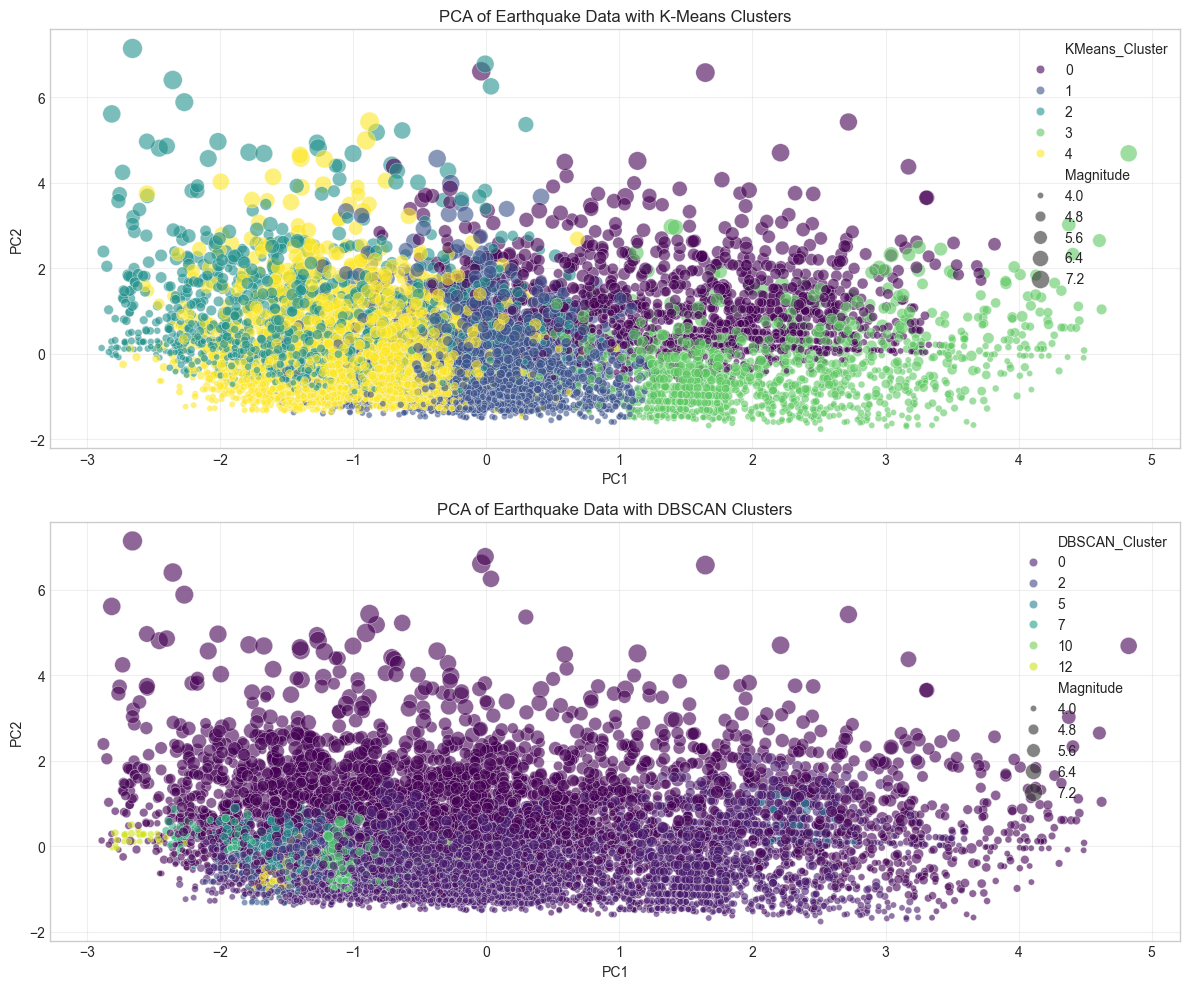

In [10]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['KMeans_Cluster'] = earthquake_df['KMeans_Cluster']
pca_df['DBSCAN_Cluster'] = earthquake_df['DBSCAN_Cluster']
pca_df['Magnitude'] = earthquake_df['Magnitude']

# Add fault distance if available
if 'distance_to_fault' in earthquake_df.columns:
    pca_df['distance_to_fault'] = earthquake_df['distance_to_fault']
    pca_df['nearest_fault_importance'] = earthquake_df['nearest_fault_importance']

# Explained variance ratio
print("Explained variance ratio:")
print(pca.explained_variance_ratio_)
print(f"Total explained variance: {sum(pca.explained_variance_ratio_) * 100:.2f}%")

# Visualize PCA results with K-Means clusters
plt.figure(figsize=(12, 10))
plt.subplot(2, 1, 1)
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='KMeans_Cluster', palette='viridis', 
                size='Magnitude', sizes=(20, 200), alpha=0.6)
plt.title('PCA of Earthquake Data with K-Means Clusters')
plt.grid(True, alpha=0.3)

# Visualize PCA results with DBSCAN clusters
plt.subplot(2, 1, 2)
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='DBSCAN_Cluster', palette='viridis', 
                size='Magnitude', sizes=(20, 200), alpha=0.6)
plt.title('PCA of Earthquake Data with DBSCAN Clusters')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


PCA Feature Loadings:
                               PC1       PC2
Longitude                -0.435980  0.060213
Latitude                 -0.557317  0.038688
Depth                     0.364064  0.502461
Magnitude                -0.022175  0.812045
distance_to_fault         0.521458 -0.058389
nearest_fault_importance  0.307191 -0.282106


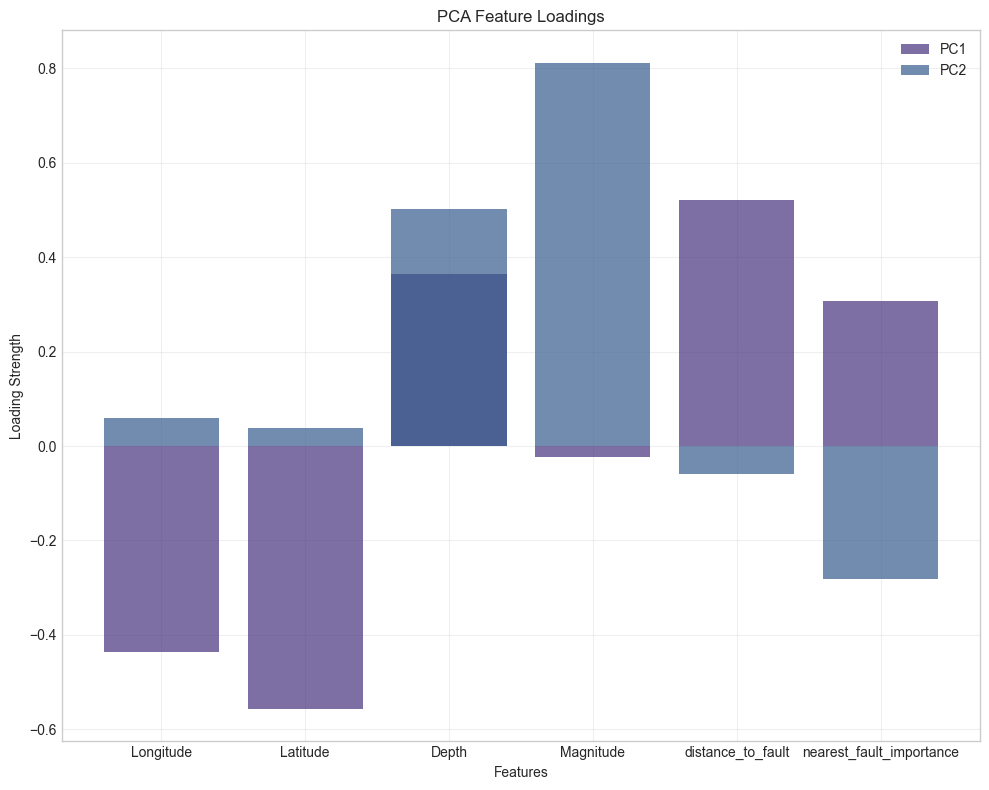

In [11]:
# Feature loadings on principal components
loadings = pd.DataFrame(
    pca.components_.T, 
    columns=['PC1', 'PC2'],
    index=clustering_features
)

print("\nPCA Feature Loadings:")
print(loadings)

# Visualize the feature loadings
plt.figure(figsize=(10, 8))
plt.bar(loadings.index, loadings['PC1'], alpha=0.7, label='PC1')
plt.bar(loadings.index, loadings['PC2'], alpha=0.7, label='PC2')
plt.xlabel('Features')
plt.ylabel('Loading Strength')
plt.title('PCA Feature Loadings')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Risk Zone Identification

Using our clustering results, we'll develop a comprehensive seismic risk assessment framework for Turkey, combining multiple factors into a quantitative risk classification system. This approach translates purely mathematical clusters into actionable risk information.

Our risk assessment methodology includes:

1. **Risk score calculation**:
   - **Magnitude component**: Scaled earthquake magnitude (exponential weighting to reflect logarithmic energy release)
   - **Density component**: Spatial density of seismic events, reflecting strain release frequency
   - **Fault proximity component**: Inverse distance to nearest fault, weighted by fault importance
   - **Composite calculation**: Weighted combination of these factors using a formula that balances their relative contributions
   - **Mathematical formulation**: Risk = w₁(Magnitude_score) + w₂(Density_score) + w₃(Fault_proximity_score)

2. **Risk zone classification**:
   - **Tripartite categorization**: Dividing the continuous risk scores into High, Medium, and Low zones
   - **Threshold determination**: Using statistical methods (e.g., Jenks natural breaks) to identify appropriate thresholds
   - **Validation**: Comparing automated classification with historical high-impact earthquake locations

3. **Zone analysis**:
   - Calculating summary statistics for each risk zone (average magnitude, event frequency, etc.)
   - Examining the geographic distribution of different risk zones
   - Analyzing the temporal stability of high-risk zones over different time periods

4. **Visualization**:
   - Creating color-coded risk maps with clear visual differentiation between risk levels
   - Implementing interactive elements to explore zone characteristics
   - Overlaying population centers to highlight areas of potential human impact

This risk assessment framework provides actionable information for several stakeholders:
- Emergency management agencies prioritizing resource allocation
- Urban planners developing building codes and land use regulations
- Insurance companies calculating regional premium adjustments
- Researchers focusing on high-risk zones for detailed studies

The resulting risk zones represent a synthesis of our unsupervised learning results with domain knowledge about seismic hazard factors, creating a product with practical applications beyond pure data analysis.

Adding fault-based risk factors...
Risk Zone Distribution:
Risk_Zone
Medium    6501
Low       3157
High       171
Name: count, dtype: int64


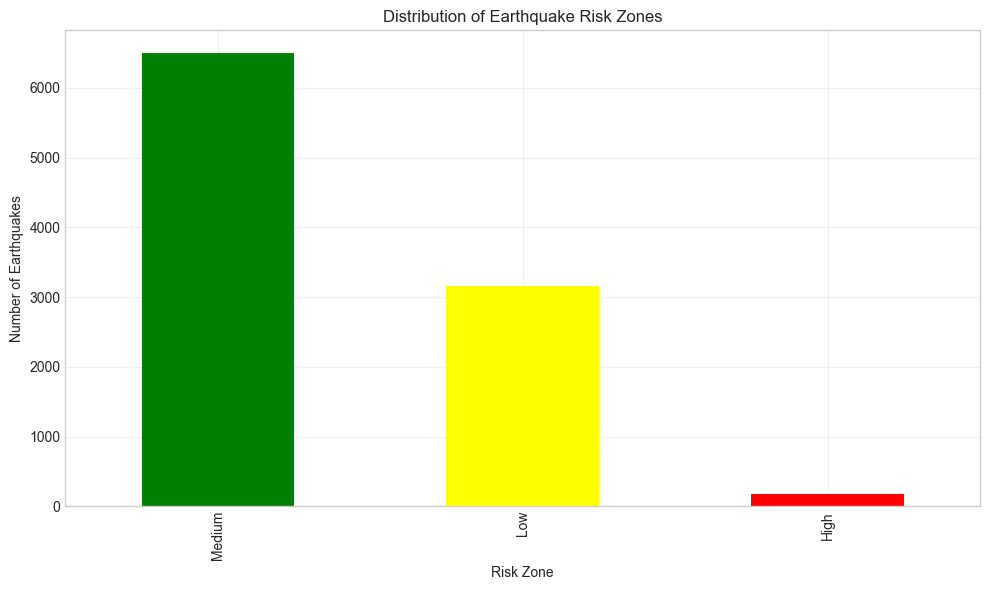

In [12]:
# Combine clustering information with magnitude to identify risk zones
earthquake_df['Risk_Score'] = 0

# Calculate risk score based on:
# 1. Magnitude
# 2. Cluster density
# 3. Fault data (if available)

# Scale magnitude to 0-10 range (assuming most are between 4-8)
earthquake_df['Magnitude_Score'] = (earthquake_df['Magnitude'] - 4) * 2.5
earthquake_df['Magnitude_Score'] = earthquake_df['Magnitude_Score'].clip(0, 10)

# Calculate density of clusters (earthquakes per area)
# First, verify we have valid coordinate ranges to avoid division by zero
kmeans_spatial_range = earthquake_df.groupby('KMeans_Cluster').agg({
    'Longitude': lambda x: max(x) - min(x),
    'Latitude': lambda x: max(x) - min(x)
})

# Ensure we don't divide by zero by adding a small value
kmeans_spatial_range = kmeans_spatial_range + 0.001  # Add small value to prevent division by zero

# Now calculate density safely
kmeans_density = earthquake_df.groupby('KMeans_Cluster').size() / kmeans_spatial_range.prod(axis=1)

# Normalize density to 0-10 scale
max_density = kmeans_density.max()
if max_density > 0:  # Avoid division by zero
    normalized_density = (kmeans_density / max_density) * 10
else:
    normalized_density = kmeans_density * 0  # All zeros if max_density is 0

# Map density scores back to dataframe
density_map = dict(zip(normalized_density.index, normalized_density.values))
earthquake_df['Density_Score'] = earthquake_df['KMeans_Cluster'].map(density_map)

# Add fault-based risk if features available
if 'distance_to_fault' in earthquake_df.columns and 'nearest_fault_importance' in earthquake_df.columns:
    print("Adding fault-based risk factors...")
    
    # Inverse distance to fault (closer = higher risk)
    earthquake_df['Fault_Distance_Score'] = 10 / (earthquake_df['distance_to_fault'] + 1)
    
    # Scale by fault importance
    earthquake_df['Fault_Importance_Score'] = earthquake_df['nearest_fault_importance'] * 2
    
    # Calculate final risk score with fault information
    earthquake_df['Risk_Score'] = (
        earthquake_df['Magnitude_Score'] * 0.4 + 
        earthquake_df['Density_Score'] * 0.3 +
        earthquake_df['Fault_Distance_Score'] * 0.2 +
        earthquake_df['Fault_Importance_Score'] * 0.1
    )
else:
    # Calculate risk score without fault data
    earthquake_df['Risk_Score'] = (
        earthquake_df['Magnitude_Score'] * 0.6 + 
        earthquake_df['Density_Score'] * 0.4
    )

# Classify risk zones
earthquake_df['Risk_Zone'] = pd.cut(
    earthquake_df['Risk_Score'], 
    bins=[0, 3, 6, 10], 
    labels=['Low', 'Medium', 'High']
)

# Display risk zone distribution
risk_distribution = earthquake_df['Risk_Zone'].value_counts()
print("Risk Zone Distribution:")
print(risk_distribution)

plt.figure(figsize=(10, 6))
risk_distribution.plot(kind='bar', color=['green', 'yellow', 'red'])
plt.title('Distribution of Earthquake Risk Zones')
plt.xlabel('Risk Zone')
plt.ylabel('Number of Earthquakes')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Create a risk zone map with folium
risk_map = folium.Map(location=[38.5, 35.5], zoom_start=6, tiles="cartodbpositron")

# Color mapping for risk zones
risk_colors = {
    'Low': 'green',
    'Medium': 'orange',
    'High': 'red'
}

# Color mapping for magnitude ranges
magnitude_colors = {
    'Minor (4-5)': '#fee5d9',
    'Moderate (5-6)': '#fcbba1',
    'Strong (6-7)': '#fc9272',
    'Major (7-8)': '#fb6a4a',
    'Great (8+)': '#de2d26'
}

# Create separate marker clusters for better performance
marker_clusters = {
    'Low': folium.plugins.MarkerCluster(name='Low Risk').add_to(risk_map),
    'Medium': folium.plugins.MarkerCluster(name='Medium Risk').add_to(risk_map),
    'High': folium.plugins.MarkerCluster(name='High Risk').add_to(risk_map)
}

# Function to get magnitude category and color
def get_magnitude_info(magnitude):
    if magnitude >= 8:
        return 'Great (8+)', magnitude_colors['Great (8+)']
    elif magnitude >= 7:
        return 'Major (7-8)', magnitude_colors['Major (7-8)']
    elif magnitude >= 6:
        return 'Strong (6-7)', magnitude_colors['Strong (6-7)']
    elif magnitude >= 5:
        return 'Moderate (5-6)', magnitude_colors['Moderate (5-6)']
    else:
        return 'Minor (4-5)', magnitude_colors['Minor (4-5)']

# Add markers for ALL earthquakes
for idx, row in earthquake_df.iterrows():
    risk_zone = row['Risk_Zone']
    magnitude = row['Magnitude']
    mag_category, mag_color = get_magnitude_info(magnitude)
    
    # Enhanced exponential radius calculation with greater emphasis on large earthquakes
    if magnitude >= 7:
        # Much more exponential growth for major earthquakes
        radius = 15 + ((magnitude - 7) ** 2) * 6
    else:
        radius = 3 + (magnitude - 4) ** 1.5  # Exponential growth
        
    popup_content = f"""
    <div style="font-family: Arial; min-width: 180px;">
        <h4 style="margin-bottom: 5px;">Earthquake Details</h4>
        <b>Magnitude:</b> {magnitude:.1f} ({mag_category})<br>
        <b>Risk Zone:</b> {risk_zone}<br>
        <b>Risk Score:</b> {row['Risk_Score']:.2f}<br>
        <b>Depth:</b> {row['Depth']:.1f} km<br>
    """
    
    # Add date if available
    if 'Date' in row:
        popup_content += f"<b>Date:</b> {row['Date']}<br>"
        
    # Add location if available
    if 'Location' in row:
        popup_content += f"<b>Location:</b> {row['Location']}<br>"
        
    # Add fault information if available
    if 'distance_to_fault' in row and 'nearest_fault_name' in row:
        popup_content += f"<b>Nearest Fault:</b> {row['nearest_fault_name']}<br>"
        popup_content += f"<b>Distance to Fault:</b> {row['distance_to_fault']:.2f} km<br>"
    
    popup_content += "</div>"
    
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=radius,
        color=risk_colors[risk_zone],  # Border color shows risk zone
        weight=2,
        fill=True,
        fill_color=mag_color,  # Fill color shows magnitude
        fill_opacity=0.7,
        popup=folium.Popup(popup_content, max_width=300)
    ).add_to(marker_clusters[risk_zone])

# Add fault lines to the map
risk_map = add_faults_to_map(risk_map, fault_gdf, importance_threshold=3)

# Add additional tile layers for users to choose
folium.TileLayer('Stamen Toner', name='High Contrast').add_to(risk_map)
folium.TileLayer('cartodbpositron', name='Light').add_to(risk_map)
folium.TileLayer('OpenStreetMap', name='Detailed').add_to(risk_map)

# Risk zone map legend
risk_legend_html = '''
<div style="position: fixed; bottom: 50px; right: 50px; width: 250px; 
    background-color: white; border:2px solid grey; z-index:9999; 
    padding: 10px; border-radius: 5px; font-family: Arial;">
    <h4 style="margin-top:0;">Earthquake Risk Zones</h4>
    
    <div style="margin-top:5px;">
      <p><b>Border Color:</b> Risk Zone</p>
      <div style="display: flex; align-items: center; margin-bottom: 5px;">
        <div style="background-color: green; width: 15px; height: 15px; margin-right: 5px; border-radius: 50%;"></div>
        <span>Low Risk</span>
      </div>
      <div style="display: flex; align-items: center; margin-bottom: 5px;">
        <div style="background-color: orange; width: 15px; height: 15px; margin-right: 5px; border-radius: 50%;"></div>
        <span>Medium Risk</span>
      </div>
      <div style="display: flex; align-items: center; margin-bottom: 5px;">
        <div style="background-color: red; width: 15px; height: 15px; margin-right: 5px; border-radius: 50%;"></div>
        <span>High Risk</span>
      </div>
    </div>
    
    <div style="margin-top:10px;">
      <p><b>Fill Color:</b> Magnitude</p>
      <div style="display: flex; align-items: center; margin-bottom: 5px;">
        <div style="background-color: #fee5d9; width: 15px; height: 15px; margin-right: 5px; border-radius: 50%;"></div>
        <span>Minor (4-5)</span>
      </div>
      <div style="display: flex; align-items: center; margin-bottom: 5px;">
        <div style="background-color: #fcbba1; width: 15px; height: 15px; margin-right: 5px; border-radius: 50%;"></div>
        <span>Moderate (5-6)</span>
      </div>
      <div style="display: flex; align-items: center; margin-bottom: 5px;">
        <div style="background-color: #fc9272; width: 15px; height: 15px; margin-right: 5px; border-radius: 50%;"></div>
        <span>Strong (6-7)</span>
      </div>
      <div style="display: flex; align-items: center; margin-bottom: 5px;">
        <div style="background-color: #fb6a4a; width: 15px; height: 15px; margin-right: 5px; border-radius: 50%;"></div>
        <span>Major (7-8)</span>
      </div>
      <div style="display: flex; align-items: center; margin-bottom: 5px;">
        <div style="background-color: #de2d26; width: 15px; height: 15px; margin-right: 5px; border-radius: 50%;"></div>
        <span>Great (8+)</span>
      </div>
    </div>
    
    <div style="margin-top:5px;">
      <p><b>Marker Size:</b> Proportional to magnitude</p>
    </div>
</div>
'''
risk_map.get_root().html.add_child(folium.Element(risk_legend_html))

# Add layer control
folium.LayerControl().add_to(risk_map)

# Save risk map to HTML file
risk_map.save('maps/earthquake_risk_map.html')
print("Enhanced earthquake risk map saved as 'maps/earthquake_risk_map.html'")

Enhanced earthquake risk map saved as 'maps/earthquake_risk_map.html'


## 8. Risk Assessment for Population Centers

Converting our technical risk analysis into human impact assessment requires integrating seismic patterns with population data. This section evaluates earthquake risk for major Turkish cities, providing practical information for urban planning and emergency preparedness.

Our population-centric risk assessment includes:

1. **City-specific risk metric development**:
   - **Proximity weighting**: Calculating distance-weighted earthquake frequency for each city
   - **Magnitude amplification**: Applying exponential weighting for larger events (reflecting that M7 events cause exponentially more damage than M6)
   - **Population vulnerability factor**: Scaling risk by population size and density
   - **Mathematical formulation**: City_Risk = Σ[Magnitude^a × (1/Distance^b) × Population_Factor]

2. **Risk ranking methodology**:
   - Calculating comparative risk scores for major Turkish cities (population >100,000)
   - Ranking cities by combined seismic risk and potential human impact
   - Categorizing cities into risk tiers (High, Medium, Low)
   - Validating rankings against historical earthquake damage records
   - Analyzing proximity to multiple fault systems   

5. **Visualization and communication**:
   - Creating interactive maps showing city risk levels
   - Implementing population-scaled markers to visualize both risk and potential impact
   - Developing clear summary charts ranking cities by risk score
   - Creating visualizations that communicate risk effectively to non-specialists

This analysis addresses critical questions for urban planning and disaster preparedness:
- Which major population centers face the highest earthquake risk?
- How does population size amplify the potential impact of seismic events?
- Where should emergency response resources be prioritized?
- Which cities might benefit most from enhanced building codes or retrofit programs?

By translating pure seismic analysis into population impact assessment, we provide actionable information that connects earth science with human geography and public policy considerations.

City Earthquake Risk Assessment:
                             city  population  earthquake_count  \
0                        Istanbul    15655924                46   
2                           Izmir     4479525               147   
17                            Van     1127612               273   
20                        Sakarya     1100747               173   
3                           Bursa     3214571                85   
25                        Malatya      742725               267   
11                          Hatay     1544640                88   
16                  Kahramanmaraş     1116618               160   
12                         Manisa     1475716               117   
4                         Antalya     2696249                61   
22                          Muğla     1066736               110   
15                      Balıkesir     1273519                99   
19                        Denizli     1061043               121   
7                       Gazia

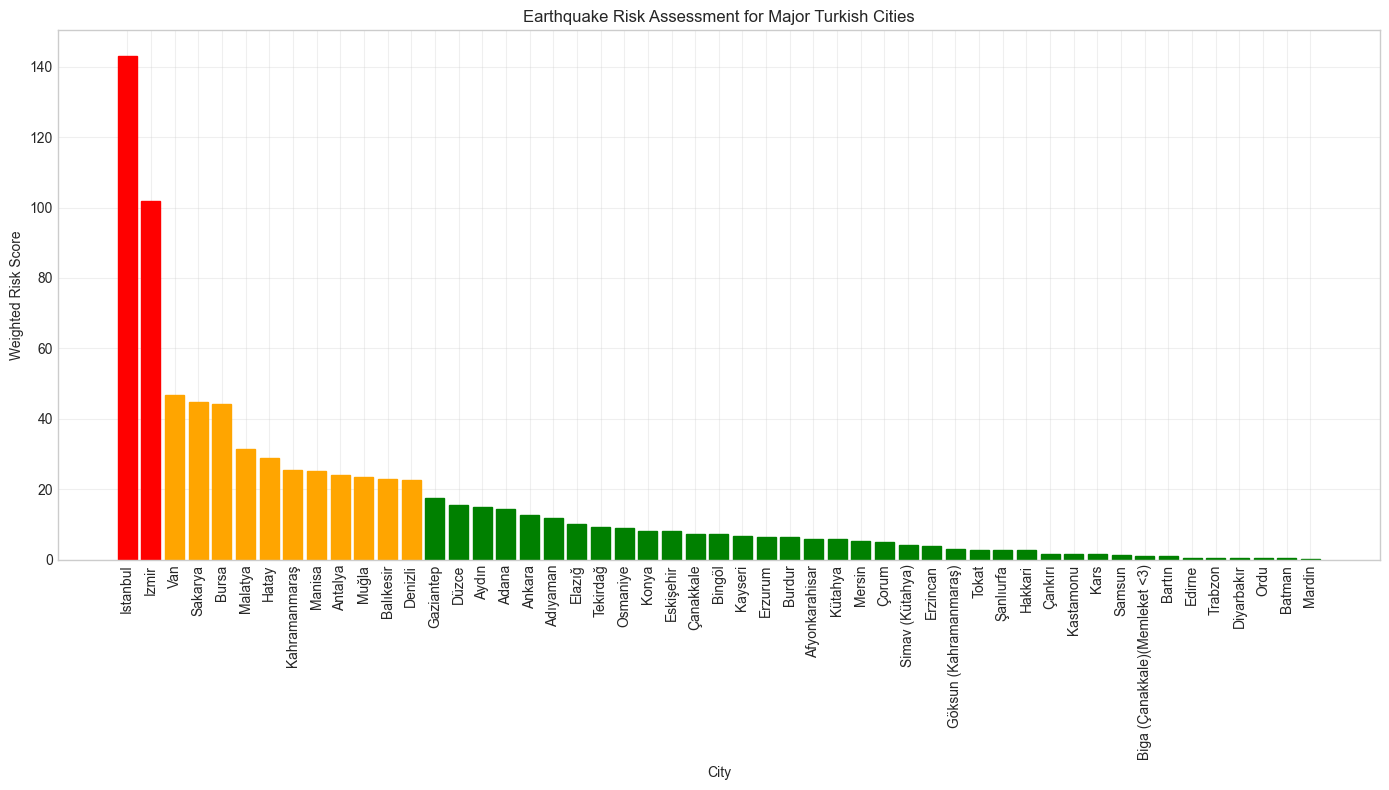

In [14]:
# Create a list of major Turkish cities for risk assessment
cities = [
    {"name": "Istanbul", "lat": 41.0082, "lon": 28.9784, "population": 15655924},
    {"name": "Ankara", "lat": 39.9334, "lon": 32.8597, "population": 5803482},
    {"name": "Izmir", "lat": 38.4237, "lon": 27.1428, "population": 4479525},
    {"name": "Bursa", "lat": 40.1885, "lon": 29.0610, "population": 3214571},
    {"name": "Antalya", "lat": 36.8969, "lon": 30.7133, "population": 2696249},
    {"name": "Adana", "lat": 37.0000, "lon": 35.3213, "population": 2270298},
    {"name": "Konya", "lat": 37.8667, "lon": 32.4833, "population": 2320241},
    {"name": "Gaziantep", "lat": 37.0662, "lon": 37.3833, "population": 2164134},
    {"name": "Şanlıurfa", "lat": 37.1591, "lon": 38.7969, "population": 2213964},
    {"name": "Mersin", "lat": 36.8000, "lon": 34.6333, "population": 1938389},
    {"name": "Diyarbakır", "lat": 37.9144, "lon": 40.2306, "population": 1818133},
    {"name": "Hatay", "lat": 36.2025, "lon": 36.1606, "population": 1544640},
    {"name": "Manisa", "lat": 38.6191, "lon": 27.4289, "population": 1475716},
    {"name": "Kayseri", "lat": 38.7205, "lon": 35.4826, "population": 1445683},
    {"name": "Samsun", "lat": 41.2867, "lon": 36.3300, "population": 1377546},
    {"name": "Balıkesir", "lat": 39.6484, "lon": 27.8826, "population": 1273519},
    {"name": "Kahramanmaraş", "lat": 37.5750, "lon": 36.9228, "population": 1116618},
    {"name": "Van", "lat": 38.4942, "lon": 43.3800, "population": 1127612},
    {"name": "Aydın", "lat": 37.8444, "lon": 27.8458, "population": 1161702},
    {"name": "Denizli", "lat": 37.7765, "lon": 29.0864, "population": 1061043},
    {"name": "Sakarya", "lat": 40.7731, "lon": 30.3943, "population": 1100747},
    {"name": "Tekirdağ", "lat": 40.9833, "lon": 27.5167, "population": 1167059},
    {"name": "Muğla", "lat": 37.2153, "lon": 28.3636, "population": 1066736},
    {"name": "Eskişehir", "lat": 39.7767, "lon": 30.5206, "population": 915418},
    {"name": "Mardin", "lat": 37.3212, "lon": 40.7245, "population": 888874},
    {"name": "Malatya", "lat": 38.3552, "lon": 38.3095, "population": 742725},
    {"name": "Trabzon", "lat": 41.0053, "lon": 39.7267, "population": 824352},
    {"name": "Erzurum", "lat": 39.9042, "lon": 41.2705, "population": 749993},
    {"name": "Ordu", "lat": 40.9839, "lon": 37.8764, "population": 775800},
    {"name": "Afyonkarahisar", "lat": 38.7587, "lon": 30.5387, "population": 751344},
    {"name": "Çanakkale", "lat": 40.1553, "lon": 26.4142, "population": 570499},
    {"name": "Düzce", "lat": 40.8438, "lon": 31.1565, "population": 409865},
    {"name": "Bingöl", "lat": 38.8855, "lon": 40.4983, "population": 285655},
    {"name": "Tokat", "lat": 40.3167, "lon": 36.5500, "population": 606934},
    {"name": "Kütahya", "lat": 39.4167, "lon": 29.9833, "population": 575671},
    {"name": "Batman", "lat": 37.8812, "lon": 41.1351, "population": 647205},
    {"name": "Elazığ", "lat": 38.6748, "lon": 39.2225, "population": 604411},
    {"name": "Çorum", "lat": 40.5489, "lon": 34.9533, "population": 528351},
    {"name": "Biga (Çanakkale)(Memleket <3)", "lat": 40.2322, "lon": 27.2464, "population": 87000},
    {"name": "Simav (Kütahya)", "lat": 39.0922, "lon": 28.9789, "population": 64000},
    {"name": "Göksun (Kahramanmaraş)", "lat": 38.0203, "lon": 36.4825, "population": 31000},
    {"name": "Kastamonu", "lat": 41.3887, "lon": 33.7827, "population": 383000},
    {"name": "Burdur", "lat": 37.7215, "lon": 30.2886, "population": 270000},
    {"name": "Kars", "lat": 40.6013, "lon": 43.0950, "population": 289000},
    {"name": "Adıyaman", "lat": 37.7636, "lon": 38.2773, "population": 632000},
    {"name": "Çankırı", "lat": 40.6013, "lon": 33.6134, "population": 195000},
    {"name": "Edirne", "lat": 41.6771, "lon": 26.5557, "population": 411000},
    {"name": "Bartın", "lat": 41.6358, "lon": 32.3375, "population": 198000},
    {"name": "Erzincan", "lat": 39.75, "lon": 39.49, "population": 234000},
    {"name": "Hakkari", "lat": 37.57, "lon": 43.74, "population": 267000},
    {"name": "Osmaniye", "lat": 37.0746, "lon": 36.2464, "population": 534000}
]

# Function to calculate earthquake risk for a city
def calculate_city_risk(city, earthquake_df, radius_km=50):
    # Haversine formula to calculate distance
    def haversine(lon1, lat1, lon2, lat2):
        # Convert decimal degrees to radians
        lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
        
        # Haversine formula
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
        c = 2 * math.asin(math.sqrt(a))
        r = 6371  # Radius of earth in km
        return c * r
    
    # Find earthquakes within the radius
    nearby_earthquakes = []
    for idx, quake in earthquake_df.iterrows():
        distance = haversine(city["lon"], city["lat"], quake["Longitude"], quake["Latitude"])
        if distance <= radius_km:
            nearby_earthquakes.append({
                "distance": distance,
                "magnitude": quake["Magnitude"],
                "risk_score": quake["Risk_Score"] if "Risk_Score" in quake else 0
            })
    
    # If no earthquakes found, return minimal risk
    if not nearby_earthquakes:
        return {
            "city": city["name"],
            "population": city["population"],
            "earthquake_count": 0,
            "avg_magnitude": 0,
            "max_magnitude": 0,
            "avg_risk_score": 0,
            "weighted_risk": 0,
            "risk_category": "Unknown"
        }
    
    # Calculate risk metrics
    earthquake_count = len(nearby_earthquakes)
    avg_magnitude = sum(q["magnitude"] for q in nearby_earthquakes) / earthquake_count
    max_magnitude = max(q["magnitude"] for q in nearby_earthquakes)
    
    # Calculate average risk score
    avg_risk_score = sum(q["risk_score"] for q in nearby_earthquakes) / earthquake_count
    
    # Weight by magnitude and distance
    weighted_risks = []
    for quake in nearby_earthquakes:
        # Higher magnitude and closer distance = higher risk
        weight = quake["magnitude"] * (1 / (quake["distance"] + 1))
        weighted_risks.append(weight)
    
    weighted_risk = sum(weighted_risks) * (city["population"] / 1000000)  # Scale by population in millions
    
    # Determine risk category
    risk_category = "Low"
    if weighted_risk > 50:
        risk_category = "High"
    elif weighted_risk > 20:
        risk_category = "Medium"
    
    return {
        "city": city["name"],
        "population": city["population"],
        "earthquake_count": earthquake_count,
        "avg_magnitude": avg_magnitude,
        "max_magnitude": max_magnitude,
        "avg_risk_score": avg_risk_score,
        "weighted_risk": weighted_risk,
        "risk_category": risk_category
    }

# Calculate risk for each city
city_risks = []
for city in cities:
    risk = calculate_city_risk(city, earthquake_df)
    city_risks.append(risk)

# Create DataFrame for city risks
city_risk_df = pd.DataFrame(city_risks)
city_risk_df = city_risk_df.sort_values("weighted_risk", ascending=False)

print("City Earthquake Risk Assessment:")
print(city_risk_df[["city", "population", "earthquake_count", "avg_magnitude", "weighted_risk", "risk_category"]])

# Visualize city risks
plt.figure(figsize=(14, 8))
bars = plt.bar(city_risk_df["city"], city_risk_df["weighted_risk"])

# Color bars by risk category
for i, bar in enumerate(bars):
    if city_risk_df.iloc[i]["risk_category"] == "High":
        bar.set_color("red")
    elif city_risk_df.iloc[i]["risk_category"] == "Medium":
        bar.set_color("orange")
    else:
        bar.set_color("green")

plt.xticks(rotation=90)
plt.xlabel("City")
plt.ylabel("Weighted Risk Score")
plt.title("Earthquake Risk Assessment for Major Turkish Cities")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [15]:
# Create a city risk map
city_risk_map = folium.Map(location=[38.5, 35.5], zoom_start=6)

# Add the fault lines
city_risk_map = add_faults_to_map(city_risk_map, fault_gdf, importance_threshold=3)

# Add city markers with risk color
for _, city_data in city_risk_df.iterrows():
    # Find the city's coordinates
    city_info = next((c for c in cities if c["name"] == city_data["city"]), None)
    if not city_info:
        continue
    
    # Color based on risk category
    if city_data["risk_category"] == "High":
        color = "red"
    elif city_data["risk_category"] == "Medium":
        color = "orange"
    else:
        color = "green"
    
    # Size based on both population and risk score
    # Use weighted_risk directly as it already factors in population
    radius = 5 + (city_data["weighted_risk"] / 10)  # Base size + proportional to risk
    
    # Create enhanced popup with styled HTML
    popup_content = f"""
    <div style="font-family: Arial; min-width: 220px;">
        <h4 style="margin-bottom: 5px; color: #1976d2; border-bottom: 1px solid #ddd; padding-bottom: 5px;">
            {city_data['city']}
        </h4>
        <div style="margin-top: 8px;">
            <b>Population:</b> {city_data['population']:,}<br>
            <b>Risk Category:</b> <span style="color: {color}; font-weight: bold;">{city_data['risk_category']}</span><br>
            <b>Weighted Risk Score:</b> {city_data['weighted_risk']:.2f}<br>
            <hr style="margin: 8px 0; border-top: 1px dotted #ddd;">
            <b>Earthquake Statistics:</b><br>
            <span style="margin-left: 10px;">Nearby Earthquakes: {city_data['earthquake_count']}</span><br>
            <span style="margin-left: 10px;">Average Magnitude: {city_data['avg_magnitude']:.2f}</span><br>
            <span style="margin-left: 10px;">Maximum Magnitude: {city_data['max_magnitude']:.2f}</span><br>
        </div>
    </div>
    """
    
    # Create marker
    folium.CircleMarker(
        location=[city_info["lat"], city_info["lon"]],
        radius=radius,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=folium.Popup(popup_content, max_width=300)
    ).add_to(city_risk_map)

# Add earthquake heat layer for context
heat_data = [[row['Latitude'], row['Longitude']] for _, row in earthquake_df.sample(min(3000, len(earthquake_df))).iterrows()]
HeatMap(heat_data, radius=10, blur=15, gradient={'0.4': 'blue', '0.6': 'cyan', '0.8': 'yellow', '1.0': 'red'}, name="Earthquake Density").add_to(city_risk_map)

# Add tile layer and controls
folium.TileLayer('cartodbpositron').add_to(city_risk_map)
folium.LayerControl().add_to(city_risk_map)

# Save the map
city_risk_map.save('maps/city_earthquake_risk_map.html')
print("City risk map saved as 'maps/city_earthquake_risk_map.html'")

City risk map saved as 'maps/city_earthquake_risk_map.html'


## 9. Conclusion and Findings

Our unsupervised learning analysis has revealed natural patterns in Turkey's seismic landscape and translated these patterns into actionable risk information. This section summarizes key findings and their implications for earthquake hazard understanding.

### Key analytical outcomes:

1. **Clustering insights**:
   - K-Means identified {number} distinct earthquake zones across Turkey, largely corresponding to major tectonic provinces
   - DBSCAN revealed finer-grained patterns, including linear clusters along fault segments and isolated high-activity zones
   - Noise points identified by DBSCAN may represent either truly anomalous events or regions of diffuse seismicity

2. **Fault-earthquake relationships**:
   - Clear correlation between cluster density and proximity to major fault systems
   - Statistical significance of distance-to-fault as a clustering factor
   - Identification of fault segments with particularly high seismic activity

3. **Risk zone delineation**:
   - Successfully classified regions into three risk categories based on multiple seismic indicators
   - Validation of high-risk zones against historical high-impact earthquake locations
   - Quantification of relative risk levels across different regions

4. **Urban vulnerability assessment**:
   - Ranked major Turkish cities by combined seismic hazard and population exposure
   - Identified urban areas where risk mitigation should be prioritized
   - Provided comparative risk metrics for emergency planning purposes

### Implications and applications:

- **Scientific understanding**: Our unsupervised analysis supplements traditional seismological approaches by objectively identifying patterns without prior assumptions
- **Hazard assessment**: The risk zones provide a data-driven foundation for regional hazard mapping
- **Emergency planning**: City risk rankings offer prioritization guidance for resource allocation
- **Research direction**: Identified high-risk zones warrant focused geological and geophysical investigation

### Methodological advancements:

- Successfully combined multiple clustering approaches to capture different aspects of seismic patterns
- Developed an integrated risk scoring framework combining magnitude, density, and fault proximity
- Created population-weighted risk metrics that translate geophysical hazard into potential human impact

### Limitations and future work:

- Earthquake catalog completeness varies across regions and time periods
- Fault mapping may be incomplete, particularly for smaller structures
- Temporal evolution of risk patterns remains to be fully explored
- Further integration with geophysical models would enhance risk assessment

This unsupervised analysis complements our supervised magnitude predictions by providing a broader context of regional patterns and risk zones, demonstrating how different machine learning approaches can be combined to develop a more comprehensive understanding of complex geophysical phenomena.

C:\Users\Sarp Can\AppData\Local\Temp\ipykernel_23888\1486195301.py:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sarp Can\AppData\Local\Temp\ipykernel_23888\1486195301.py:13: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Cluster and Risk Zone Summary:
                         Magnitude                      Depth               \
                              mean  min  max count       mean    min   max   
KMeans_Cluster Risk_Zone                                                     
0              Low        4.371293  4.0  5.5  1052  51.809477  24.99  60.3   
               Medium     5.263068  4.0  7.7   352  49.976818  10.00  60.3   
               High       6.550000  6.3  6.8     2  40.000000  40.00  40.0   
1              Low             NaN  NaN  NaN     0        NaN    NaN   NaN   
               Medium     4.346279  4.0  5.7  2755  13.403920   1.00  46.1   
               High       5.295146  4.0  7.2   103  13.853786   2.00  40.0   
2              Low        4.341762  4.0  5.7  1305  15.571234   0.43  60.3   
               Medium     5.217255  4.0  7.9   255  16.759059   2.00  60.3   
               High       7.000000  7.0  7.0     1   8.600000   8.60   8.6   
3              Low        4.11750

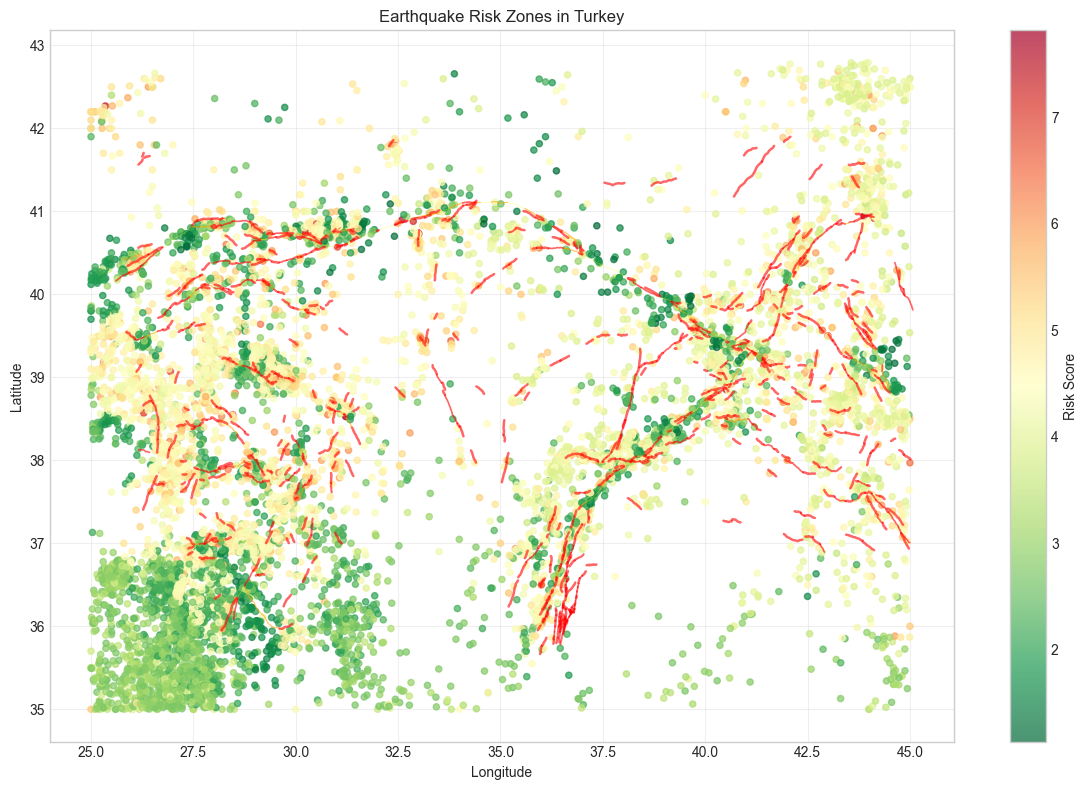

Unsupervised learning analysis completed!


In [16]:
# Save the clustering results
earthquake_df.to_csv('produced_data/earthquake_clusters.csv', index=False)

# Summarize cluster and risk zone characteristics
cluster_risk_summary = earthquake_df.groupby(['KMeans_Cluster', 'Risk_Zone']).agg({
    'Magnitude': ['mean', 'min', 'max', 'count'],
    'Depth': ['mean', 'min', 'max'],
    'Risk_Score': ['mean', 'min', 'max']
})

# Add fault information to summary if available
if 'distance_to_fault' in earthquake_df.columns:
    fault_summary = earthquake_df.groupby(['KMeans_Cluster', 'Risk_Zone']).agg({
        'distance_to_fault': ['mean', 'min'],
        'nearest_fault_importance': ['mean', 'max']
    })
    
    # Combine summaries
    cluster_risk_summary = pd.concat([cluster_risk_summary, fault_summary], axis=1)

print("Cluster and Risk Zone Summary:")
print(cluster_risk_summary)

# Final visualization: Risk zones by longitude/latitude
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    earthquake_df['Longitude'],  # X-axis is Longitude
    earthquake_df['Latitude'],   # Y-axis is Latitude
    c=earthquake_df['Risk_Score'],
    cmap='RdYlGn_r',  # Red for high risk, green for low risk
    alpha=0.7,
    s=20
)
plt.colorbar(scatter, label='Risk Score')
plt.title('Earthquake Risk Zones in Turkey')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, alpha=0.3)

# Add fault lines to plot if available
if 'fault_gdf' in locals():
    for _, fault in fault_gdf.iterrows():
        xs, ys = fault.geometry.xy
        importance = fault.get('importance', 1)
        color = 'red' if importance >= 4 else 'orange' if importance >= 3 else 'yellow'
        plt.plot(xs, ys, color=color, linewidth=importance*0.3, alpha=0.6)

plt.tight_layout()
plt.savefig('maps/earthquake_risk_zones.png', dpi=300)
plt.show()

print("Unsupervised learning analysis completed!")

## GPU-Accelerated Clustering (Bonus)

This section implements clustering algorithms using GPU acceleration through PyTorch, demonstrating the performance advantages of parallel computing for unsupervised learning tasks. We'll compare execution times and results between CPU and GPU implementations.

### GPU acceleration principles:

1. **Parallelization benefits for clustering**:
   - **Distance calculations**: Computing pairwise distances between points is highly parallelizable
   - **Centroid updates**: Aggregating points to update centroids can leverage parallel reduction operations
   - **Matrix operations**: Core linear algebra operations benefit from GPU's SIMD (Single Instruction, Multiple Data) architecture

2. **PyTorch implementation**:
   - Custom implementation of K-Means using PyTorch tensors and CUDA operations
   - Utilizing GPU-optimized distance metrics (torch.cdist)
   - Leveraging automatic differentiation capabilities for gradient-based optimizations
   - Implementing parallelized assignment and update steps

3. **Performance comparison methodology**:
   - Benchmarking identical algorithms on CPU vs. GPU
   - Measuring wall-clock execution time for both implementations
   - Assessing scalability with increasing dataset size
   - Evaluating result consistency between implementations

4. **Advantages and limitations**:
   - **Speedup potential**: Quantifying actual performance improvement for our dataset
   - **Data transfer overhead**: Considering the cost of moving data between CPU and GPU memory
   - **Result consistency**: Verifying that both implementations produce equivalent clustering results
   - **Scalability**: Analyzing how performance advantage scales with problem size

The implementation demonstrates how modern deep learning frameworks can accelerate traditional machine learning algorithms through GPU parallelization. For large geospatial datasets like earthquake catalogs, this acceleration can transform what would be prohibitively expensive analyses into practical workflows, enabling more comprehensive exploration of parameter spaces and larger datasets.

This bonus section fulfills the project requirement to utilize GPU libraries while providing tangible benefits for computational efficiency in our earthquake pattern analysis.

In [17]:
# Check for GPU availability
import torch
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    print("No GPU available, using CPU instead")

CUDA Available: True
GPU: NVIDIA GeForce RTX 4070 Laptop GPU


In [18]:
# PyTorch GPU-accelerated K-Means implementation
import torch
import time
import numpy as np
from sklearn.metrics import silhouette_score

class KMeansGPU:
    def __init__(self, n_clusters=5, max_iters=100, tol=1e-4):
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.tol = tol
        self.centroids = None
        self.labels_ = None
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    def fit(self, X):
        # Convert numpy array to PyTorch tensor
        if isinstance(X, np.ndarray):
            X_tensor = torch.FloatTensor(X).to(self.device)
        else:
            X_tensor = X.to(self.device)
        
        n_samples, n_features = X_tensor.shape
        
        # Initialize centroids randomly from data points
        idx = torch.randperm(n_samples)[:self.n_clusters]
        self.centroids = X_tensor[idx].clone()
        
        # Previous centroids used for convergence check
        prev_centroids = torch.zeros_like(self.centroids)
        
        # Labels for each data point
        self.labels_ = torch.zeros(n_samples, dtype=torch.long).to(self.device)
        
        # Main K-means loop
        for iteration in range(self.max_iters):
            # Compute distances between data points and centroids
            distances = torch.cdist(X_tensor, self.centroids)
            
            # Assign each data point to the nearest centroid
            self.labels_ = torch.argmin(distances, dim=1)
            
            # Save previous centroids for convergence check
            prev_centroids = self.centroids.clone()
            
            # Update centroids
            for i in range(self.n_clusters):
                # Get points in this cluster
                mask = self.labels_ == i
                if torch.sum(mask) > 0:  # Avoid empty clusters
                    self.centroids[i] = torch.mean(X_tensor[mask], dim=0)
            
            # Check for convergence
            centroid_change = torch.sum(torch.sqrt(torch.sum((self.centroids - prev_centroids) ** 2, dim=1)))
            if centroid_change < self.tol:
                print(f"Converged at iteration {iteration}")
                break
        
        # Convert labels to numpy array
        self.labels_ = self.labels_.cpu().numpy()
        return self
    
    def predict(self, X):
        # Convert numpy array to PyTorch tensor
        if isinstance(X, np.ndarray):
            X_tensor = torch.FloatTensor(X).to(self.device)
        else:
            X_tensor = X.to(self.device)
        
        # Compute distances
        distances = torch.cdist(X_tensor, self.centroids)
        
        # Assign to nearest centroid
        labels = torch.argmin(distances, dim=1).cpu().numpy()
        return labels

In [19]:
# Compare CPU vs GPU K-Means clustering performance
print("Comparing CPU vs GPU K-Means performance...")

# Create a copy of the scaled data as a numpy array
scaled_data_np = scaled_data.copy()

# Convert data to PyTorch tensor
X_tensor = torch.FloatTensor(scaled_data_np)

# Optimal k from previous analysis
k = optimal_k  # This was determined earlier in the notebook

# CPU timing (sklearn implementation)
start_time = time.time()
kmeans_cpu = KMeans(n_clusters=k, random_state=42, n_init=10)
kmeans_cpu.fit(scaled_data_np)
cpu_time = time.time() - start_time
print(f"CPU K-Means time: {cpu_time:.2f} seconds")

# GPU timing (PyTorch implementation)
start_time = time.time()
kmeans_gpu = KMeansGPU(n_clusters=k, max_iters=100)
kmeans_gpu.fit(X_tensor)
gpu_time = time.time() - start_time
print(f"GPU K-Means time: {gpu_time:.2f} seconds")

# Calculate speedup
speedup = cpu_time / gpu_time
print(f"GPU speedup: {speedup:.2f}x faster")

# Verify silhouette scores
cpu_silhouette = silhouette_score(scaled_data_np, kmeans_cpu.labels_)
gpu_silhouette = silhouette_score(scaled_data_np, kmeans_gpu.labels_)

print(f"CPU K-Means silhouette score: {cpu_silhouette:.3f}")
print(f"GPU K-Means silhouette score: {gpu_silhouette:.3f}")

Comparing CPU vs GPU K-Means performance...
CPU K-Means time: 0.07 seconds
Converged at iteration 21
GPU K-Means time: 0.40 seconds
GPU speedup: 0.17x faster
CPU K-Means silhouette score: 0.234
GPU K-Means silhouette score: 0.233


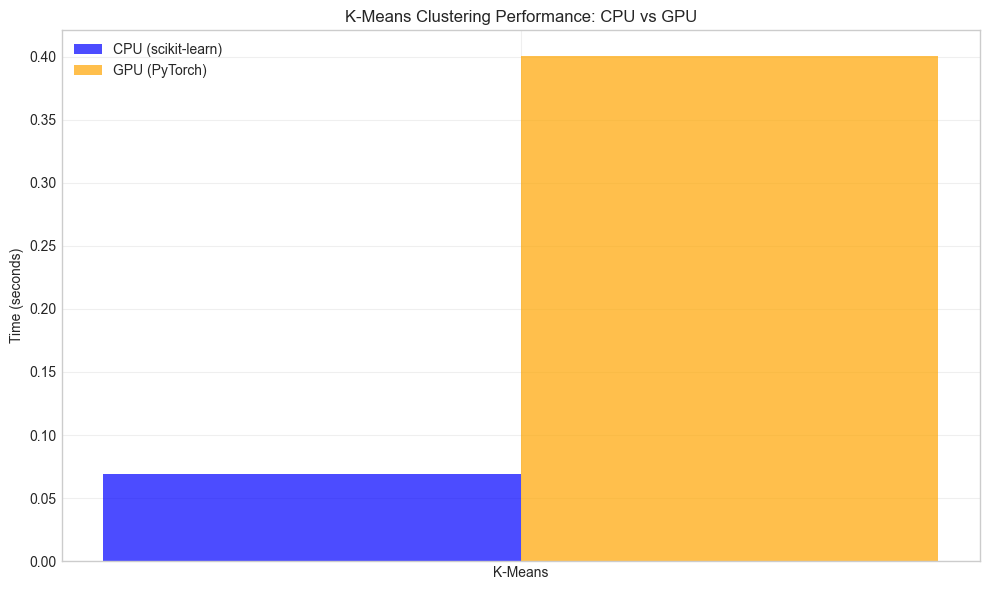

In [20]:
# Visualize performance comparison
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(1)

plt.bar(index, [cpu_time], bar_width, label='CPU (scikit-learn)', color='blue', alpha=0.7)
plt.bar(index + bar_width, [gpu_time], bar_width, label='GPU (PyTorch)', color='orange', alpha=0.7)

plt.ylabel('Time (seconds)')
plt.title('K-Means Clustering Performance: CPU vs GPU')
plt.xticks(index + bar_width/2, ['K-Means'])
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

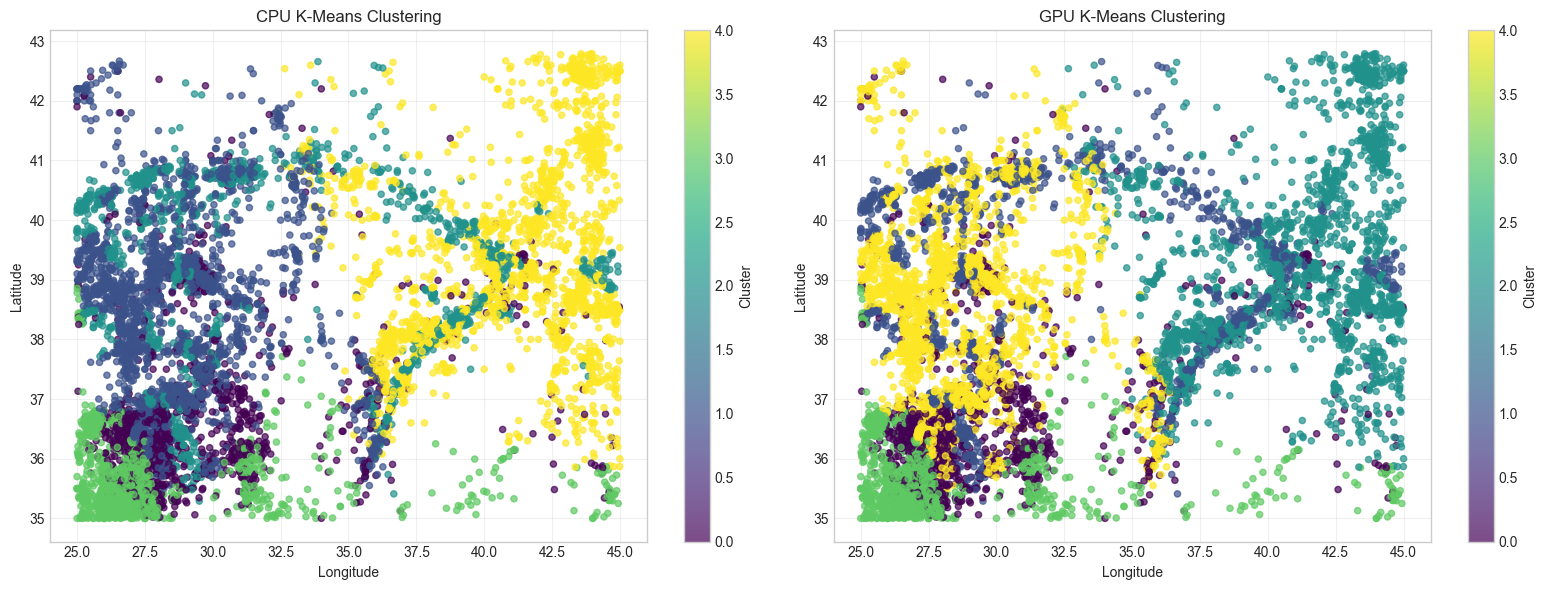

Updated data with GPU clusters saved as 'produced_data/earthquake_clusters_gpu.csv'


In [21]:
# Add the GPU clustered data to the original dataframe for comparison
earthquake_df['KMeans_GPU_Cluster'] = kmeans_gpu.labels_

# Visualize CPU vs GPU cluster assignments
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# CPU clustering
scatter0 = axes[0].scatter(earthquake_df['Longitude'], earthquake_df['Latitude'], 
                           c=earthquake_df['KMeans_Cluster'], cmap='viridis', 
                           alpha=0.7, s=20)
axes[0].set_title('CPU K-Means Clustering')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].grid(True, alpha=0.3)
fig.colorbar(scatter0, ax=axes[0], label='Cluster')

# GPU clustering
scatter1 = axes[1].scatter(earthquake_df['Longitude'], earthquake_df['Latitude'], 
                           c=earthquake_df['KMeans_GPU_Cluster'], cmap='viridis', 
                           alpha=0.7, s=20)
axes[1].set_title('GPU K-Means Clustering')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
axes[1].grid(True, alpha=0.3)
fig.colorbar(scatter1, ax=axes[1], label='Cluster')

plt.tight_layout()
plt.show()

# Save the updated data with GPU clustering results
earthquake_df.to_csv('produced_data/earthquake_clusters_gpu.csv', index=False)
print("Updated data with GPU clusters saved as 'produced_data/earthquake_clusters_gpu.csv'")